# Read data from .mat and plot FGM (tow-yo, P5)

FD method, output: statistics and upstream/downstream feature of the fastest growth rate, critical level, perturbation energy for KH instabilities.

In [1]:
# %matplotlib notebook
%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
import scipy as sp
import matplotlib.pyplot as plt
import scipy.io as sio
import io
import gsw

from scipy import integrate
from matplotlib import cm
from scipy.interpolate import interp1d

In [2]:
def dataFGM(section, exnum):
    import os
    import glob

    towyo_files = np.sort(glob.glob(os.path.join(mdirec + 'codes/TG_SI_TY_' + section + "*" + exnum + "*")))

    # Growth rate, imaginary phase speed, real phase speed, numbers of zero-crossing, wave vector of the FGM
    GRs = np.squeeze(np.concatenate([sio.loadmat(file)["GR"] for file in towyo_files] , axis=0))
    CIs = np.squeeze(np.concatenate([sio.loadmat(file)["CI"] for file in towyo_files] , axis=0))
    CRs = np.squeeze(np.concatenate([sio.loadmat(file)["CR"] for file in towyo_files] , axis=0))
    IIs = np.squeeze(np.concatenate([sio.loadmat(file)["II"] for file in towyo_files] , axis=0))
    KFGMs = np.squeeze(np.concatenate([sio.loadmat(file)["KFGM"] for file in towyo_files] , axis=0))
    LONs = np.squeeze(np.concatenate([sio.loadmat(file)["LON"] for file in towyo_files] , axis=-1))
    LATs = np.squeeze(np.concatenate([sio.loadmat(file)["LAT"] for file in towyo_files] , axis=-1))

    # profiles
    Bs = np.squeeze(np.concatenate([sio.loadmat(file)["B"] for file in towyo_files] , axis=-1))
    N2s = np.squeeze(np.concatenate([sio.loadmat(file)["N2"] for file in towyo_files] , axis=-1))
    Ris = np.squeeze(np.concatenate([sio.loadmat(file)["Ri"] for file in towyo_files] , axis=-1))
    Vs = np.squeeze(np.concatenate([sio.loadmat(file)["V"] for file in towyo_files] , axis=-1))
    Vzs = np.squeeze(np.concatenate([sio.loadmat(file)["Vz"] for file in towyo_files] , axis=-1))
    Vzzs = np.squeeze(np.concatenate([sio.loadmat(file)["Vzz"] for file in towyo_files] , axis=-1))

    # FGM in terms of w
    Ws = np.squeeze(np.concatenate([sio.loadmat(file)["W"] for file in towyo_files] , axis=-1))
    # CLs = np.squeeze(np.concatenate([sio.loadmat(file)["CL"] for file in towyo_files] , axis=0))

    towyo_files_others = np.sort(glob.glob(os.path.join(mdirec[:-6] + 'proc_data/TY_' + section + "*")))

    # interface height, bottom height, crtical level (w maximum) 
    zw = np.squeeze(sio.loadmat(towyo_files[0])["zw"])
    ideps = np.squeeze(np.concatenate([sio.loadmat(file)["zo"] for file in towyo_files_others] , axis=1))
    bdeps = np.squeeze(np.concatenate([sio.loadmat(file)["bdepth"] for file in towyo_files_others] , axis=1))    
    cdeps = np.zeros(LONs.shape, dtype='f')
    nans = np.isnan(np.nanmax(Ws.real, axis=0))
    cdeps[~nans] = zw[np.int_(np.nanargmax(Ws.real[:,~nans], axis=0))]
    cdeps[nans] = np.nan
    
    FGM_towyo = xr.Dataset({'GR': (['site'], 2*np.pi/GRs/3600), 
                           'CI': (['site'], CIs),
                           'CR': (['site'], CRs),
                           'II': (['site'], IIs), 
                           'K': (['site','vector'], KFGMs),
                           'LON': (['site'], LONs), 
                           'LAT': (['site'], LATs), 
                           'zo': (['site'], ideps), 
                           'bdepth': (['site'], -bdeps),
                           'cdepth': (['site'], cdeps),
                           'iab': (['site'], ideps+bdeps),
                           'cab': (['site'], cdeps+bdeps),
                           'b': (['z', 'site'], Bs),
                           'N2': (['z', 'site'], N2s),
                           'Ri': (['z', 'site'], Ris),
                           'V': (['z', 'site'], Vs),
                           'Vz': (['z', 'site'], Vzs),
                           'Vzz': (['z', 'site'], Vzzs), #                        'CL': (['site', 'n'], CLs),
                           'W': (['z', 'site'], Ws)},
                           coords={'site': np.arange(len(LONs)),
                                   'z': zw}, #,'n': np.arange(CLs.shape[-1])
                           attrs={'title': 'FGM, tow-yo profiles'})
    return FGM_towyo

In [3]:
def datafromfile(data_name):
    data = sio.loadmat(mdirec + 'codes/' + data_name,squeeze_me = True,struct_as_record = False)
    type(data)
    dict.keys(data)

    # Growth rate, imaginary phase speed, real phase speed, numbers of zero-crossing, wave vector of the FGM
    GR = xr.DataArray(2*np.pi/data['GR']/3600, coords={"site": np.arange(len(data['LON']))}, dims=["site"], attrs={'longname': '$\sigma$: $hr^{-1}$'})
    if "GR_all" in data:
        GR_all = xr.DataArray(2*np.pi/data['GR_all']/3600, coords={"site": np.arange(len(data['LON'])), "k": data['K'], "l": data['L']}, dims=["site", "k", "l"], attrs={'longname': '$\sigma$: $hr^{-1}$'})
    else:
        GR_all = xr.DataArray(np.empty([len(data['LON']), len(data['K']), len(data['L'])])+np.nan, coords={"site": np.arange(len(data['LON'])), "k": data['K'], "l": data['L']}, dims=["site", "k", "l"], attrs={'longname': '$\sigma$: $hr^{-1}$'})
    CI = xr.DataArray(data['CI'], coords={"site": np.arange(len(data['LON']))}, dims=["site"])
    CR = xr.DataArray(data['CR'], coords={"site": np.arange(len(data['LON']))}, dims=["site"])
    II = xr.DataArray(data['II'], coords={"site": np.arange(len(data['LON']))}, dims=["site"], attrs={'longname': '0-crossings'})
    KFGM = xr.DataArray(data['KFGM'], coords={"site": np.arange(len(data['LON'])), "vector": ['k' , 'l']}, dims=["site" , "vector"])
    LON = xr.DataArray(data['LON'], coords={"site": np.arange(len(data['LON']))}, dims=["site"])
    LAT = xr.DataArray(data['LAT'], coords={"site": np.arange(len(data['LON']))}, dims=["site"])

    # profiles
    B = xr.DataArray(data['B'], coords={"z":data['zw'], "site": np.arange(len(data['LON']))}, dims=["z" , "site"])
    N2 = xr.DataArray(data['N2'], coords={"z":data['zw'], "site": np.arange(len(data['LON']))}, dims=["z" , "site"])
    Ri = xr.DataArray(data['Ri'], coords={"z":data['zw'], "site": np.arange(len(data['LON']))}, dims=["z" , "site"])
    V = xr.DataArray(data['V'], coords={"z":data['zw'], "site": np.arange(len(data['LON']))}, dims=["z" , "site"])
    Vz = xr.DataArray(data['Vz'], coords={"z":data['zw'], "site": np.arange(len(data['LON']))}, dims=["z" , "site"])
    Vzz = xr.DataArray(data['Vzz'], coords={"z":data['zw'], "site": np.arange(len(data['LON']))}, dims=["z" , "site"])

    # FGM in terms of w
    W = xr.DataArray(data['W'], coords={"z":data['zw'], "site": np.arange(len(data['LON']))}, dims=["z" , "site"])
    # critical levels
    CL = xr.DataArray(data['CL'], coords={"site": np.arange(len(data['LON'])), "n": np.arange(data['CL'].shape[-1])}, dims=["site" , "n"])

    # interface height, bottom height, critical level (w maximum) height
    data0 = sio.loadmat(mdirec[:-7]+'/proc_data/'+data_name[6:-8]+'.mat',squeeze_me = True,struct_as_record = False)
    idep = xr.DataArray(data0['zo'], coords={"site": np.arange(len(data['LON']))}, dims=["site"])
    bdep = xr.DataArray(data0['bdepth'], coords={"site": np.arange(len(data['LON']))}, dims=["site"])
    cd = np.zeros(data['LON'].shape, dtype='f')
    nans = np.isnan(np.nanmax(data['W'].real, axis=0))
    cd[~nans] = data['zw'][np.int_(np.nanargmax(data['W'].real[:,~nans], axis=0))]
    cd[nans] = np.nan
    cdep = xr.DataArray(cd, coords={"site": np.arange(len(data['LON']))}, dims=["site"])
    
    FGM_towyo_ex = xr.Dataset({'GR': (['site'], GR), 
                           'GR_all': (['site', 'k', 'l'], GR_all),    
                           'CI': (['site'], CI),
                           'CR': (['site'], CR),
                           'II': (['site'], II), 
                           'K': (['site','vector'], KFGM),
                           'LON': (['site'], LON), 
                           'LAT': (['site'], LAT), 
                           'zo': (['site'], idep), 
                           'bdepth': (['site'], -bdep), 
                           'cdepth': (['site'], cdep), 
                           'b': (['z', 'site'], B),
                           'N2': (['z', 'site'], N2),
                           'Ri': (['z', 'site'], Ri),
                           'V': (['z', 'site'], V),
                           'Vz': (['z', 'site'], Vz),
                           'Vzz': (['z', 'site'], Vzz),
                           'W': (['z', 'site'], W),
                           'CL': (['site', 'n'], CL)},
                           coords={'site': np.arange(len(data['LON'])),
                                   'z': data['zw'],
                                   'n': np.arange(data['CL'].shape[-1]),
                                   'k': data['K'],
                                   'l': data['L']},
                           attrs={'title': 'FGM, tow-yo profiles, ex_'})
    return FGM_towyo_ex

In [4]:
# P5 data
mdirec='/Users/tantanmeow/Desktop/WORK/2018-2019/Jesse/sp-tg/'
FGM_towyo_P5 = dataFGM("P5", "ex1")


## 1. upstream & downstream feature

1). Growth rate

Mean growth rate in P5 = 2.1$hr^{-1}$


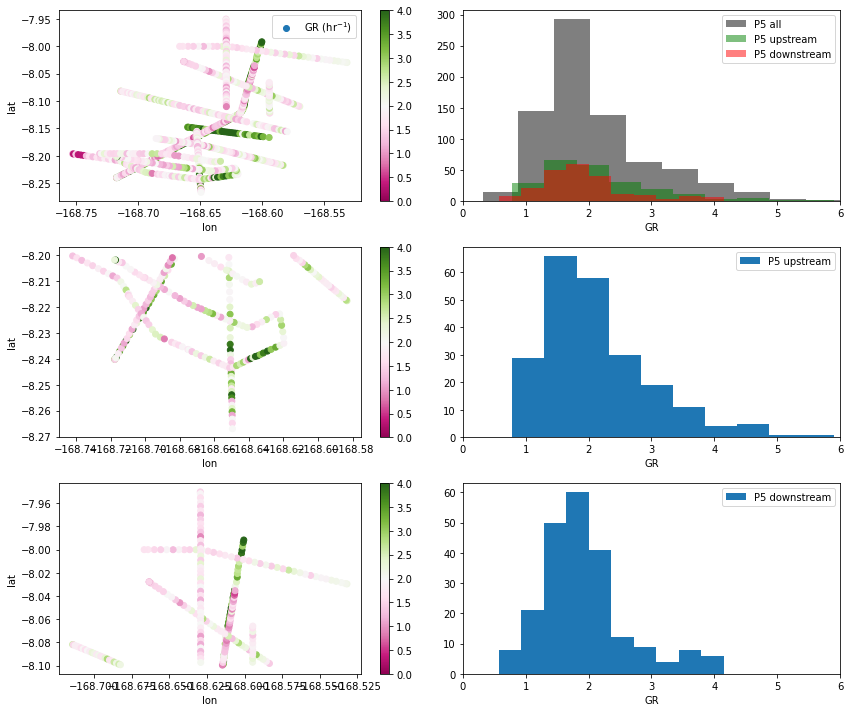

In [5]:
fig, ax =  plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

sc = ax[0,0].scatter(FGM_towyo_P5.LON, FGM_towyo_P5.LAT, c=FGM_towyo_P5.GR, marker='o',vmax=4, vmin=0, cmap=cm.PiYG, label='GR (hr$^{-1}$)')
ax[0,0].set_xlabel('lon'); ax[0,0].set_ylabel('lat'); ax[0,0].legend()
fig.colorbar(sc,label=" ",ax=ax[0,0])
# all stations 
ax[0,1].hist(FGM_towyo_P5.GR, facecolor='k', alpha=0.5, label='P5 all')
# upstream and near the crest of the sill (south of 8.2S)
ax[0,1].hist(FGM_towyo_P5.GR[FGM_towyo_P5.LAT<=-8.2], facecolor='g', alpha=0.5, label='P5 upstream')
# downstream (north of 8.1S)
ax[0,1].hist(FGM_towyo_P5.GR[FGM_towyo_P5.LAT>=-8.1], facecolor='r', alpha=0.5, label='P5 downstream')
ax[0,1].set_xlabel('GR'); ax[0,1].set_ylabel(''); ax[0,1].legend(); ax[0,1].set_xlim([0,6])

# upstream
sc = ax[1,0].scatter(FGM_towyo_P5.LON[FGM_towyo_P5.LAT<=-8.2], FGM_towyo_P5.LAT[FGM_towyo_P5.LAT<=-8.2], c=FGM_towyo_P5.GR[FGM_towyo_P5.LAT<=-8.2], marker='o',vmax=4, vmin=0, cmap=cm.PiYG, label='GR (hr$^{-1}$)')
ax[1,0].set_xlabel('lon'); ax[1,0].set_ylabel('lat'); # ax[1,0].legend()
fig.colorbar(sc,label=" ",ax=ax[1,0])
ax[1,1].hist(FGM_towyo_P5.GR[FGM_towyo_P5.LAT<=-8.2], label='P5 upstream')
ax[1,1].set_xlabel('GR'); ax[1,1].set_ylabel(''); ax[1,1].legend(); ax[1,1].set_xlim([0,6])

# downstream
sc = ax[2,0].scatter(FGM_towyo_P5.LON[FGM_towyo_P5.LAT>=-8.1], FGM_towyo_P5.LAT[FGM_towyo_P5.LAT>=-8.1], c=FGM_towyo_P5.GR[FGM_towyo_P5.LAT>=-8.1], marker='o',vmax=4, vmin=0, cmap=cm.PiYG, label='GR (hr$^{-1}$)')
ax[2,0].set_xlabel('lon'); ax[2,0].set_ylabel('lat'); # ax[1,0].legend()
fig.colorbar(sc,label=" ",ax=ax[2,0])
ax[2,1].hist(FGM_towyo_P5.GR[FGM_towyo_P5.LAT>=-8.1], label='P5 downstream')
ax[2,1].set_xlabel('GR'); ax[2,1].set_ylabel(''); ax[2,1].legend(); ax[2,1].set_xlim([0,6])

fig.tight_layout()

print('Mean growth rate in P5 = ' + str(FGM_towyo_P5.GR.mean().data.round(1)) + '$hr^{-1}$')

2) Ri and distance between the critical layer and the density interface

Text(0.5, 1.0, 'P5 2012')

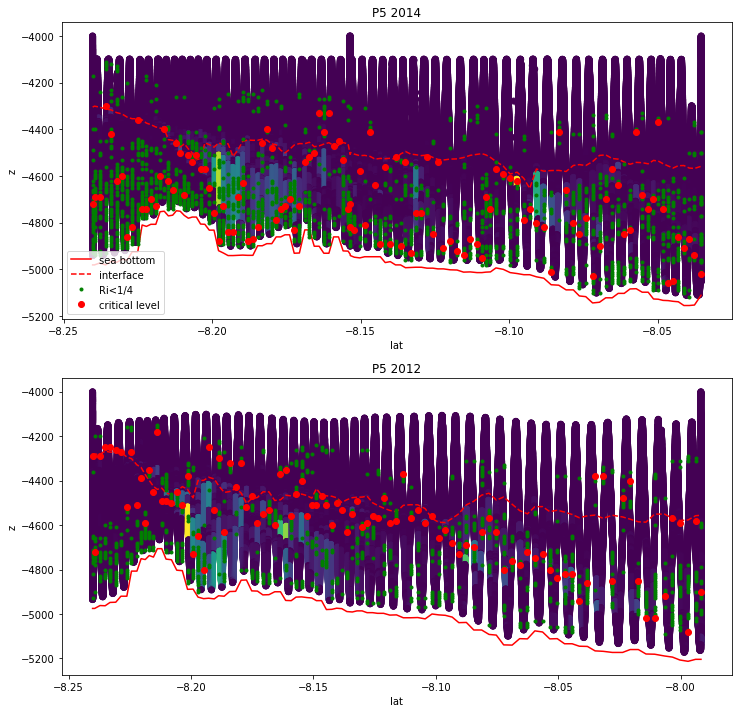

In [6]:
# a closer look at a repeated along-path section, (P5 2012 vs 2014) - ex3: add friction
FGM_towyo_2014 = datafromfile('TG_SI_TY_P5_02_2014_ex3.mat')
FGM_towyo_2012 = datafromfile('TG_SI_TY_P5_00_2012_ex3.mat')

data_2014 = sio.loadmat(mdirec[:-7]+'/proc_data/'+'TY_P5_02_2014.mat',squeeze_me = True,struct_as_record = False)
data_2012 = sio.loadmat(mdirec[:-7]+'/proc_data/'+'TY_P5_00_2012.mat',squeeze_me = True,struct_as_record = False)

fig, ax =  plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
ax[0].scatter(data_2014['lat'],data_2014['z'],c=data_2014['eps']) #c=np.log10(data_ex1['eps']))
ax[0].plot(FGM_towyo_2014.LAT, FGM_towyo_2014.bdepth, 'r-', label='sea bottom')
ax[0].plot(FGM_towyo_2014.LAT, FGM_towyo_2014.zo, 'r--', label='interface')
for i in range(len(FGM_towyo_2014.LAT)):  
    mask = FGM_towyo_2014.Ri[:,i]<1/4
    ax[0].plot(np.ones((len(FGM_towyo_2014.z[mask])))*FGM_towyo_2014.LAT[i].data, FGM_towyo_2014.z[mask], 'g.')
ax[0].plot(np.ones((len(FGM_towyo_2014.z[mask])))*FGM_towyo_2014.LAT[i].data, FGM_towyo_2014.z[mask], 'g.', label='Ri<1/4')
ax[0].plot(FGM_towyo_2014.LAT, FGM_towyo_2014.cdepth, 'ro', label='critical level')
ax[0].set_xlabel('lat'); ax[0].set_ylabel('z'); ax[0].set_title('P5 2014'); ax[0].legend()

ax[1].scatter(data_2012['lat'],data_2012['z'],c=data_2012['eps']) #c=np.log10(data_ex2['eps']))
ax[1].plot(FGM_towyo_2012.LAT, FGM_towyo_2012.bdepth, 'r-', label='sea bottom')
ax[1].plot(FGM_towyo_2012.LAT, FGM_towyo_2012.zo, 'r--', label='interface')
for i in range(len(FGM_towyo_2012.LAT)):  
    mask = FGM_towyo_2012.Ri[:,i]<1/4
    ax[1].plot(np.ones((len(FGM_towyo_2012.z[mask])))*FGM_towyo_2012.LAT[i].data, FGM_towyo_2012.z[mask], 'g.')
ax[1].plot(FGM_towyo_2012.LAT, FGM_towyo_2012.cdepth, 'ro', label='critical level')
ax[1].set_xlabel('lat'); ax[1].set_ylabel('z'); ax[1].set_title('P5 2012')


<ipython-input-3-abe64a15dde3>:9: RuntimeWarning: divide by zero encountered in true_divide
  GR_all = xr.DataArray(2*np.pi/data['GR_all']/3600, coords={"site": np.arange(len(data['LON'])), "k": data['K'], "l": data['L']}, dims=["site", "k", "l"], attrs={'longname': '$\sigma$: $hr^{-1}$'})


Text(0.5, 1.0, 'P5 2012')

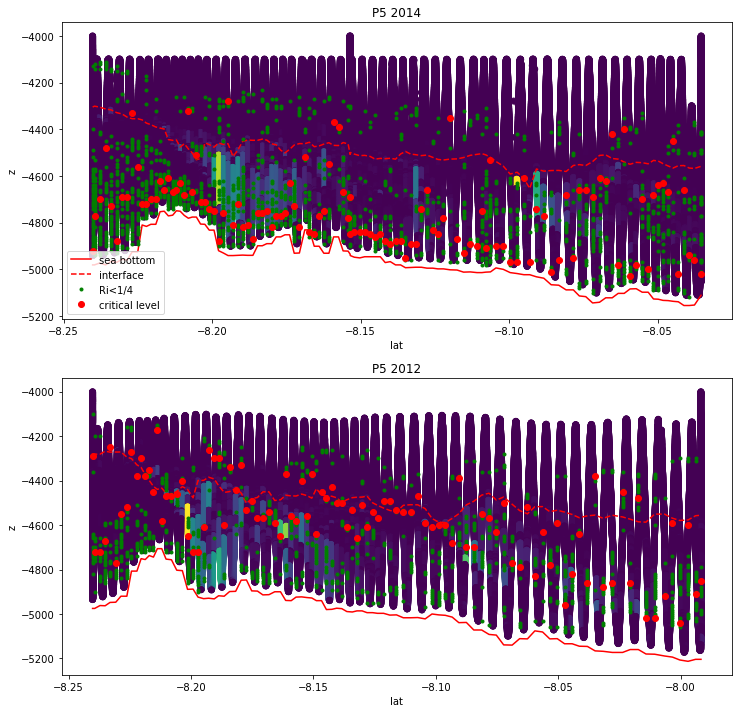

In [7]:
# a closer look at a repeated along-path section, (P5 2012 vs 2014)
FGM_towyo_2014 = datafromfile('TG_SI_TY_P5_02_2014_ex1.mat')
FGM_towyo_2012 = datafromfile('TG_SI_TY_P5_00_2012_ex1.mat')

data_2014 = sio.loadmat(mdirec[:-7]+'/proc_data/'+'TY_P5_02_2014.mat',squeeze_me = True,struct_as_record = False)
data_2012 = sio.loadmat(mdirec[:-7]+'/proc_data/'+'TY_P5_00_2012.mat',squeeze_me = True,struct_as_record = False)

fig, ax =  plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
ax[0].scatter(data_2014['lat'],data_2014['z'],c=data_2014['eps']) #c=np.log10(data_ex1['eps']))
ax[0].plot(FGM_towyo_2014.LAT, FGM_towyo_2014.bdepth, 'r-', label='sea bottom')
ax[0].plot(FGM_towyo_2014.LAT, FGM_towyo_2014.zo, 'r--', label='interface')
for i in range(len(FGM_towyo_2014.LAT)):  
    mask = FGM_towyo_2014.Ri[:,i]<1/4
    ax[0].plot(np.ones((len(FGM_towyo_2014.z[mask])))*FGM_towyo_2014.LAT[i].data, FGM_towyo_2014.z[mask], 'g.')
ax[0].plot(np.ones((len(FGM_towyo_2014.z[mask])))*FGM_towyo_2014.LAT[i].data, FGM_towyo_2014.z[mask], 'g.', label='Ri<1/4')
ax[0].plot(FGM_towyo_2014.LAT, FGM_towyo_2014.cdepth, 'ro', label='critical level')
ax[0].set_xlabel('lat'); ax[0].set_ylabel('z'); ax[0].set_title('P5 2014'); ax[0].legend()

ax[1].scatter(data_2012['lat'],data_2012['z'],c=data_2012['eps']) #c=np.log10(data_ex2['eps']))
ax[1].plot(FGM_towyo_2012.LAT, FGM_towyo_2012.bdepth, 'r-', label='sea bottom')
ax[1].plot(FGM_towyo_2012.LAT, FGM_towyo_2012.zo, 'r--', label='interface')
for i in range(len(FGM_towyo_2012.LAT)):  
    mask = FGM_towyo_2012.Ri[:,i]<1/4
    ax[1].plot(np.ones((len(FGM_towyo_2012.z[mask])))*FGM_towyo_2012.LAT[i].data, FGM_towyo_2012.z[mask], 'g.')
ax[1].plot(FGM_towyo_2012.LAT, FGM_towyo_2012.cdepth, 'ro', label='critical level')
ax[1].set_xlabel('lat'); ax[1].set_ylabel('z'); ax[1].set_title('P5 2012')


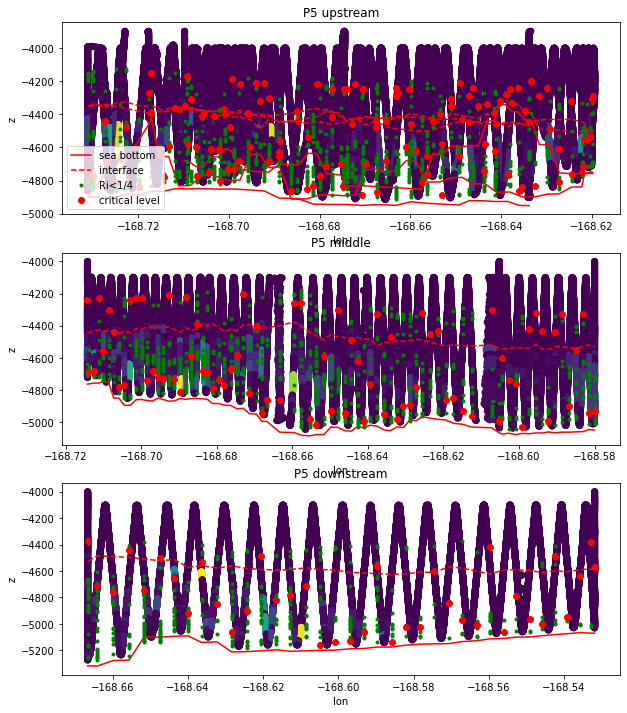

In [8]:
# a closer look at a upstream cross-section and a downstream cross-section, (P5 2012 vs 2014)
FGM_towyo_up = datafromfile('TG_SI_TY_P5_11_2014_ex1.mat')
FGM_towyo_mi = datafromfile('TG_SI_TY_P5_04_2014_ex1.mat')
FGM_towyo_do = datafromfile('TG_SI_TY_P5_06_2014_ex1.mat')
# plt.scatter(FGM_towyo_up.LON, FGM_towyo_up.LAT, c=FGM_towyo_up.GR, marker='o',vmax=4, vmin=0, cmap=cm.PiYG, label='GR (hr$^{-1}$)')
# plt.scatter(FGM_towyo_mi.LON, FGM_towyo_mi.LAT, c=FGM_towyo_mi.GR, marker='o',vmax=4, vmin=0, cmap=cm.PiYG, label='GR (hr$^{-1}$)')
# plt.scatter(FGM_towyo_do.LON, FGM_towyo_do.LAT, c=FGM_towyo_do.GR, marker='o',vmax=4, vmin=0, cmap=cm.PiYG, label='GR (hr$^{-1}$)')

data_up = sio.loadmat(mdirec[:-7]+'/proc_data/'+'TY_P5_11_2014.mat',squeeze_me = True,struct_as_record = False)
data_mi = sio.loadmat(mdirec[:-7]+'/proc_data/'+'TY_P5_04_2014.mat',squeeze_me = True,struct_as_record = False)
data_do = sio.loadmat(mdirec[:-7]+'/proc_data/'+'TY_P5_06_2014.mat',squeeze_me = True,struct_as_record = False)

fig, ax =  plt.subplots(nrows=3, ncols=1, figsize=(10, 12))
ax[0].scatter(data_up['lon'],data_up['z'],c=data_up['eps']) #c=np.log10(data_ex1['eps']))
ax[0].plot(FGM_towyo_up.LON, FGM_towyo_up.bdepth, 'r-', label='sea bottom')
ax[0].plot(FGM_towyo_up.LON, FGM_towyo_up.zo, 'r--', label='interface')
for i in range(len(FGM_towyo_up.LON)):  
    mask = FGM_towyo_up.Ri[:,i]<1/4
    ax[0].plot(np.ones((len(FGM_towyo_up.z[mask])))*FGM_towyo_up.LON[i].data, FGM_towyo_up.z[mask], 'g.')
ax[0].plot(np.ones((len(FGM_towyo_up.z[mask])))*FGM_towyo_up.LON[i].data, FGM_towyo_up.z[mask], 'g.', label='Ri<1/4')
ax[0].plot(FGM_towyo_up.LON, FGM_towyo_up.cdepth, 'ro', label='critical level')
ax[0].set_xlabel('lon'); ax[0].set_ylabel('z'); ax[0].set_title('P5 upstream'); ax[0].legend()

ax[1].scatter(data_mi['lon'],data_mi['z'],c=data_mi['eps']) #c=np.log10(data_ex1['eps']))
ax[1].plot(FGM_towyo_mi.LON, FGM_towyo_mi.bdepth, 'r-', label='sea bottom')
ax[1].plot(FGM_towyo_mi.LON, FGM_towyo_mi.zo, 'r--', label='interface')
for i in range(len(FGM_towyo_mi.LON)):  
    mask = FGM_towyo_mi.Ri[:,i]<1/4
    ax[1].plot(np.ones((len(FGM_towyo_mi.z[mask])))*FGM_towyo_mi.LON[i].data, FGM_towyo_mi.z[mask], 'g.')
ax[1].plot(FGM_towyo_mi.LON, FGM_towyo_mi.cdepth, 'ro', label='critical level')
ax[1].set_xlabel('lon'); ax[1].set_ylabel('z'); ax[1].set_title('P5 middle'); 

ax[-1].scatter(data_do['lon'],data_do['z'],c=data_do['eps']) #c=np.log10(data_ex1['eps']))
ax[-1].plot(FGM_towyo_do.LON, FGM_towyo_do.bdepth, 'r-', label='sea bottom')
ax[-1].plot(FGM_towyo_do.LON, FGM_towyo_do.zo, 'r--', label='interface')
for i in range(len(FGM_towyo_do.LON)):  
    mask = FGM_towyo_do.Ri[:,i]<1/4
    ax[-1].plot(np.ones((len(FGM_towyo_do.z[mask])))*FGM_towyo_do.LON[i].data, FGM_towyo_do.z[mask], 'g.')
ax[-1].plot(FGM_towyo_do.LON, FGM_towyo_do.cdepth, 'ro', label='critical level')
ax[-1].set_xlabel('lon'); ax[-1].set_ylabel('z'); ax[-1].set_title('P5 downstream'); 


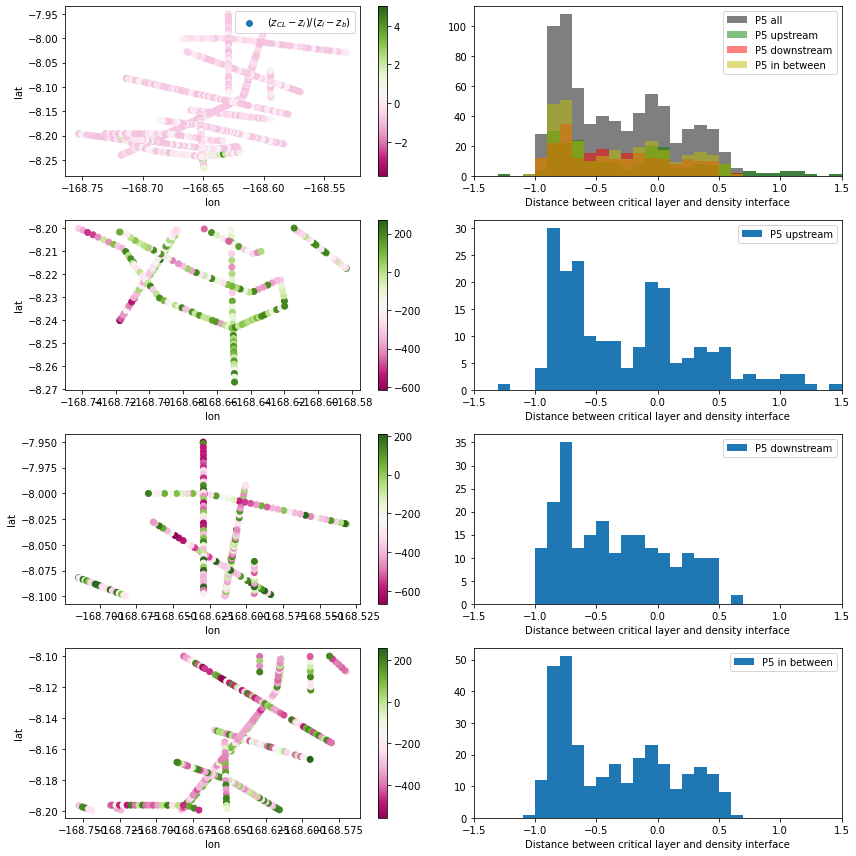

In [9]:
fig, ax =  plt.subplots(nrows=4, ncols=2, figsize=(12, 12))

sc = ax[0,0].scatter(FGM_towyo_P5.LON, FGM_towyo_P5.LAT, c=(FGM_towyo_P5.cdepth-FGM_towyo_P5.zo)/(FGM_towyo_P5.zo-FGM_towyo_P5.bdepth), marker='o', cmap=cm.PiYG, label='$(z_{CL}-z_i)/(z_i-z_b)$')
ax[0,0].set_xlabel('lon'); ax[0,0].set_ylabel('lat'); ax[0,0].legend()
fig.colorbar(sc,label=" ",ax=ax[0,0])
# all stations 
ax[0,1].hist((FGM_towyo_P5.cdepth-FGM_towyo_P5.zo)/(FGM_towyo_P5.zo-FGM_towyo_P5.bdepth), facecolor='k', alpha=0.5, label='P5 all', bins=np.arange(-2, 2, .1))
# upstream and near the crest of the sill (south of 8.2S)
ax[0,1].hist((FGM_towyo_P5.cdepth[FGM_towyo_P5.LAT<=-8.2]-FGM_towyo_P5.zo[FGM_towyo_P5.LAT<=-8.2])/(FGM_towyo_P5.zo[FGM_towyo_P5.LAT<=-8.2]-FGM_towyo_P5.bdepth[FGM_towyo_P5.LAT<=-8.2]), facecolor='g', alpha=0.5, label='P5 upstream', bins=np.arange(-2, 2, .1))
# downstream (north of 8.1S)
ax[0,1].hist((FGM_towyo_P5.cdepth[FGM_towyo_P5.LAT>=-8.1]-FGM_towyo_P5.zo[FGM_towyo_P5.LAT>=-8.1])/(FGM_towyo_P5.zo[FGM_towyo_P5.LAT>=-8.1]-FGM_towyo_P5.bdepth[FGM_towyo_P5.LAT>=-8.1]), facecolor='r', alpha=0.5, label='P5 downstream', bins=np.arange(-2, 2, .1))
# in between
ax[0,1].hist((FGM_towyo_P5.cdepth[(FGM_towyo_P5.LAT<-8.1)*(FGM_towyo_P5.LAT>-8.2)]-FGM_towyo_P5.zo[(FGM_towyo_P5.LAT<-8.1)*(FGM_towyo_P5.LAT>-8.2)])/(FGM_towyo_P5.zo[(FGM_towyo_P5.LAT<-8.1)*(FGM_towyo_P5.LAT>-8.2)]-FGM_towyo_P5.bdepth[(FGM_towyo_P5.LAT<-8.1)*(FGM_towyo_P5.LAT>-8.2)]), facecolor='y', alpha=0.5, label='P5 in between', bins=np.arange(-2, 2, .1))
ax[0,1].set_xlabel('Distance between critical layer and density interface'); ax[0,1].set_ylabel(''); ax[0,1].legend(); ax[0,1].set_xlim([-1.5,1.5])

# upstream
sc = ax[1,0].scatter(FGM_towyo_P5.LON[FGM_towyo_P5.LAT<=-8.2], FGM_towyo_P5.LAT[FGM_towyo_P5.LAT<=-8.2], c=FGM_towyo_P5.cdepth[FGM_towyo_P5.LAT<=-8.2]-FGM_towyo_P5.zo[FGM_towyo_P5.LAT<=-8.2], marker='o',cmap=cm.PiYG)
ax[1,0].set_xlabel('lon'); ax[1,0].set_ylabel('lat'); # ax[1,0].legend()
fig.colorbar(sc,label=" ",ax=ax[1,0])
ax[1,1].hist((FGM_towyo_P5.cdepth[FGM_towyo_P5.LAT<=-8.2]-FGM_towyo_P5.zo[FGM_towyo_P5.LAT<=-8.2])/(FGM_towyo_P5.zo[FGM_towyo_P5.LAT<=-8.2]-FGM_towyo_P5.bdepth[FGM_towyo_P5.LAT<=-8.2]), label='P5 upstream', bins=np.arange(-2, 2, .1))
ax[1,1].set_xlabel('Distance between critical layer and density interface'); ax[1,1].set_ylabel(''); ax[1,1].legend(); ax[1,1].set_xlim([-1.5,1.5])

# downstream
sc = ax[2,0].scatter(FGM_towyo_P5.LON[FGM_towyo_P5.LAT>=-8.1], FGM_towyo_P5.LAT[FGM_towyo_P5.LAT>=-8.1], c=FGM_towyo_P5.cdepth[FGM_towyo_P5.LAT>=-8.1]-FGM_towyo_P5.zo[FGM_towyo_P5.LAT>=-8.1], marker='o',cmap=cm.PiYG)
ax[2,0].set_xlabel('lon'); ax[2,0].set_ylabel('lat'); # ax[1,0].legend()
fig.colorbar(sc,label=" ",ax=ax[2,0])
ax[2,1].hist((FGM_towyo_P5.cdepth[FGM_towyo_P5.LAT>=-8.1]-FGM_towyo_P5.zo[FGM_towyo_P5.LAT>=-8.1])/(FGM_towyo_P5.zo[FGM_towyo_P5.LAT>=-8.1]-FGM_towyo_P5.bdepth[FGM_towyo_P5.LAT>=-8.1]), label='P5 downstream', bins=np.arange(-2, 2, .1))
ax[2,1].set_xlabel('Distance between critical layer and density interface'); ax[2,1].set_ylabel(''); ax[2,1].legend(); ax[2,1].set_xlim([-1.5,1.5])

# in between
sc = ax[-1,0].scatter(FGM_towyo_P5.LON[(FGM_towyo_P5.LAT<-8.1)*(FGM_towyo_P5.LAT>-8.2)], FGM_towyo_P5.LAT[(FGM_towyo_P5.LAT<-8.1)*(FGM_towyo_P5.LAT>-8.2)], c=FGM_towyo_P5.cdepth[(FGM_towyo_P5.LAT<-8.1)*(FGM_towyo_P5.LAT>-8.2)]-FGM_towyo_P5.zo[(FGM_towyo_P5.LAT<-8.1)*(FGM_towyo_P5.LAT>-8.2)], marker='o',cmap=cm.PiYG)
ax[-1,0].set_xlabel('lon'); ax[-1,0].set_ylabel('lat'); # ax[1,0].legend()
fig.colorbar(sc,label=" ",ax=ax[-1,0])
ax[-1,1].hist((FGM_towyo_P5.cdepth[(FGM_towyo_P5.LAT<-8.1)*(FGM_towyo_P5.LAT>-8.2)]-FGM_towyo_P5.zo[(FGM_towyo_P5.LAT<-8.1)*(FGM_towyo_P5.LAT>-8.2)])/(FGM_towyo_P5.zo[(FGM_towyo_P5.LAT<-8.1)*(FGM_towyo_P5.LAT>-8.2)]-FGM_towyo_P5.bdepth[(FGM_towyo_P5.LAT<-8.1)*(FGM_towyo_P5.LAT>-8.2)]), label='P5 in between', bins=np.arange(-2, 2, .1))
ax[-1,1].set_xlabel('Distance between critical layer and density interface'); ax[-1,1].set_ylabel(''); ax[-1,1].legend(); ax[-1,1].set_xlim([-1.5,1.5])

fig.tight_layout()


Critical level for unstable modes with growth rate less than $6hr^{-1}$

a. ex1 (FD method, inviscid background)

In [10]:
GM_towyo_2012 = sio.loadmat(mdirec+'codes/'+'P5_00_2012_ex1.mat',squeeze_me = True,struct_as_record = False)
GR_2012=2*np.pi/GM_towyo_2012['GR_all']/3600
CL_2012=GM_towyo_2012['CL_all']
ERR_K_2012=GM_towyo_2012['ERR_K_all']
ERR_B_2012=GM_towyo_2012['ERR_B_all']

GM_towyo_2014 = sio.loadmat(mdirec+'codes/'+'P5_02_2014_ex1.mat',squeeze_me = True,struct_as_record = False)
GR_2014=2*np.pi/GM_towyo_2014['GR_all']/3600
CL_2014=GM_towyo_2014['CL_all']
ERR_K_2014=GM_towyo_2014['ERR_K_all']
ERR_B_2014=GM_towyo_2014['ERR_B_all']

<ipython-input-10-84d1a58170f5>:2: RuntimeWarning: divide by zero encountered in true_divide
  GR_2012=2*np.pi/GM_towyo_2012['GR_all']/3600
<ipython-input-10-84d1a58170f5>:8: RuntimeWarning: divide by zero encountered in true_divide
  GR_2014=2*np.pi/GM_towyo_2014['GR_all']/3600


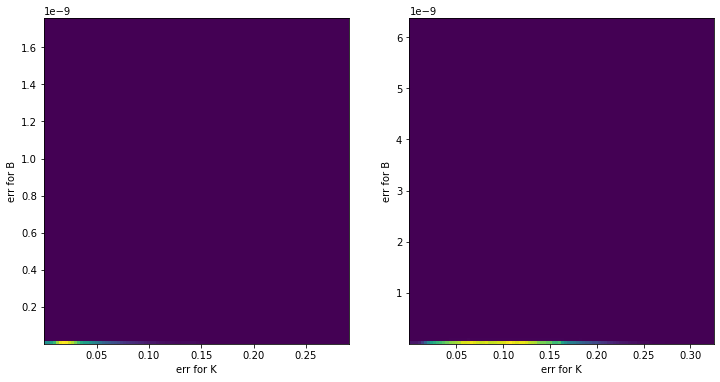

In [11]:
# check for errors
fig, ax =  plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
nans = np.isnan(CL_2012.flatten())
ax[0].hist2d(ERR_K_2012.flatten()[~nans],ERR_B_2012.flatten()[~nans], bins=100)
ax[0].set_xlabel('err for K'); ax[0].set_ylabel('err for B'); 

nans = np.isnan(CL_2014.flatten())
ax[1].hist2d(ERR_K_2014.flatten()[~nans],ERR_B_2014.flatten()[~nans], bins=100)
ax[1].set_xlabel('err for K'); ax[1].set_ylabel('err for B'); 


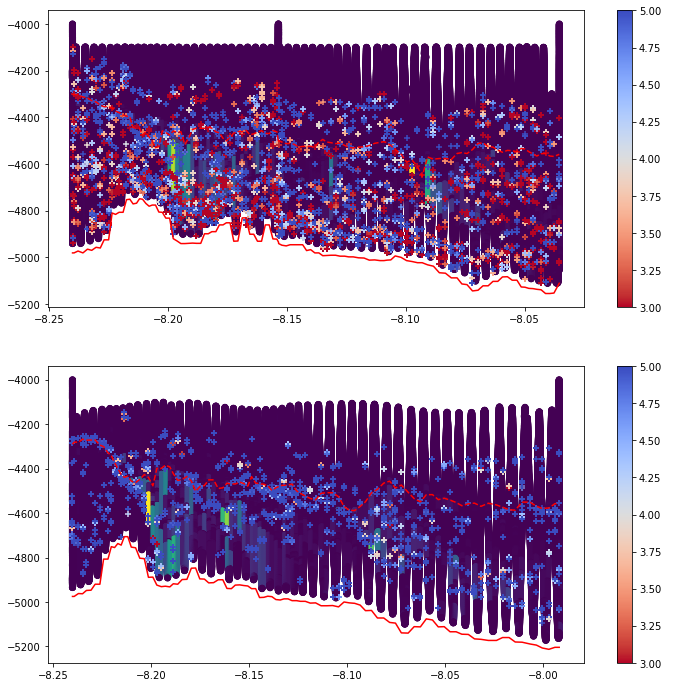

In [12]:
# critical level, GR along path
fig, ax =  plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
ax[0].scatter(data_2014['lat'],data_2014['z'],c=data_2014['eps']) #c=np.log10(data_ex2['eps']))
ax[0].plot(FGM_towyo_2014.LAT, FGM_towyo_2014.bdepth, 'r-', label='sea bottom')
ax[0].plot(FGM_towyo_2014.LAT, FGM_towyo_2014.zo, 'r--', label='interface')
for i in range(len(FGM_towyo_2014.LAT)):  
    mask = np.isnan(CL_2014[i,:,:].flatten())
    sc = ax[0].scatter(np.ones(len(CL_2014[i,:,:].flatten()[~mask]))*FGM_towyo_2014.LAT[i].data, CL_2014[i,:,:].flatten()[~mask],  c=GR_2014[i,:,:].flatten()[~mask], vmax=5, vmin=3, marker='+', cmap=cm.coolwarm_r)
fig.colorbar(sc,label=" ",ax=ax[0])

ax[1].scatter(data_2012['lat'],data_2012['z'],c=data_2012['eps']) #c=np.log10(data_ex2['eps']))
ax[1].plot(FGM_towyo_2012.LAT, FGM_towyo_2012.bdepth, 'r-', label='sea bottom')
ax[1].plot(FGM_towyo_2012.LAT, FGM_towyo_2012.zo, 'r--', label='interface')
for i in range(len(FGM_towyo_2012.LAT)):  
    mask = np.isnan(CL_2012[i,:,:].flatten())
    sc = ax[1].scatter(np.ones(len(CL_2012[i,:,:].flatten()[~mask]))*FGM_towyo_2012.LAT[i].data, CL_2012[i,:,:].flatten()[~mask],  c=GR_2012[i,:,:].flatten()[~mask], vmax=5, vmin=3, marker='+', cmap=cm.coolwarm_r)
fig.colorbar(sc,label=" ",ax=ax[1])


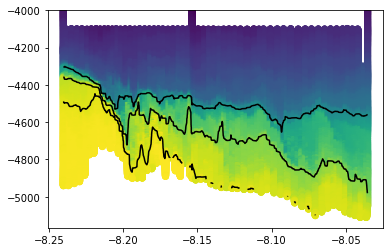

In [13]:
plt.scatter(data_2014['lat'],data_2014['z'],c=data_2014['sig4']) #c=np.log10(data_ex2['eps']))
plt.contour(data_2014['lat'],data_2014['z'],data_2014['sig4_sorted'],[1045.93, 1045.96, 1045.975],colors='k')


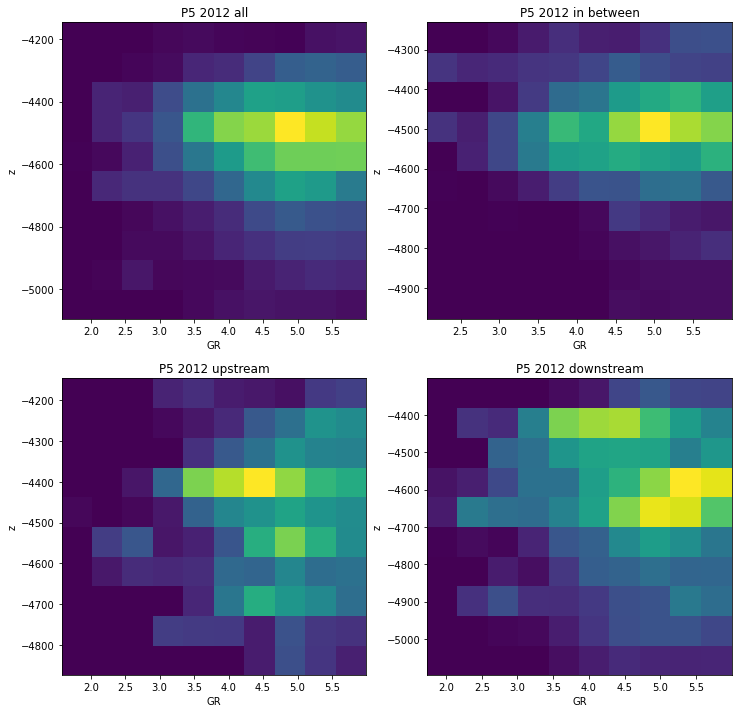

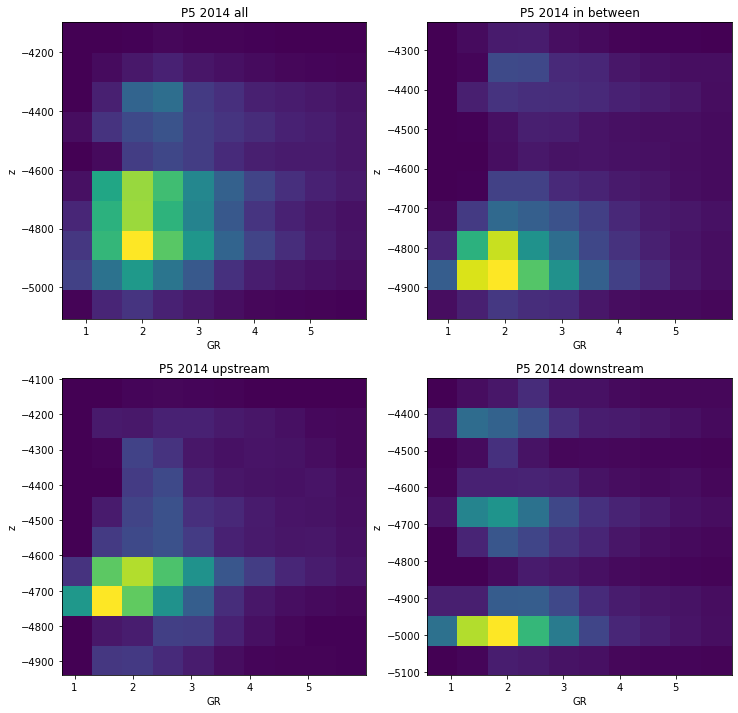

In [14]:
# critical layer & GR statistics

# 2012
fig, ax =  plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

nans = np.isnan(CL_2012.flatten())
ax[0,0].hist2d(GR_2012.flatten()[~nans],CL_2012.flatten()[~nans])
ax[0,0].set_title('P5 2012 all'); ax[0,0].set_xlabel('GR'); ax[0,0].set_ylabel('z'); 

nans = np.isnan(CL_2012[(FGM_towyo_2012.LAT<-8.1)*(FGM_towyo_2012.LAT>-8.2),:,:].flatten())
ax[0,1].hist2d(GR_2012[(FGM_towyo_2012.LAT<-8.1)*(FGM_towyo_2012.LAT>-8.2),:,:].flatten()[~nans],CL_2012[(FGM_towyo_2012.LAT<-8.1)*(FGM_towyo_2012.LAT>-8.2),:,:].flatten()[~nans])
ax[0,1].set_title('P5 2012 in between'); ax[0,1].set_xlabel('GR'); ax[0,1].set_ylabel('z'); 

nans = np.isnan(CL_2012[FGM_towyo_2012.LAT<=-8.2,:,:].flatten())
ax[1,0].hist2d(GR_2012[FGM_towyo_2012.LAT<=-8.2,:,:].flatten()[~nans],CL_2012[FGM_towyo_2012.LAT<=-8.2,:,:].flatten()[~nans])
ax[1,0].set_title('P5 2012 upstream'); ax[1,0].set_xlabel('GR'); ax[1,0].set_ylabel('z'); 

nans = np.isnan(CL_2012[FGM_towyo_2012.LAT>=-8.1,:,:].flatten())
ax[1,1].hist2d(GR_2012[FGM_towyo_2012.LAT>=-8.1,:,:].flatten()[~nans],CL_2012[FGM_towyo_2012.LAT>=-8.1,:,:].flatten()[~nans])
ax[1,1].set_title('P5 2012 downstream'); ax[1,1].set_xlabel('GR'); ax[1,1].set_ylabel('z'); 

# 2014
fig, ax =  plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

nans = np.isnan(CL_2014.flatten())
ax[0,0].hist2d(GR_2014.flatten()[~nans],CL_2014.flatten()[~nans])
ax[0,0].set_title('P5 2014 all'); ax[0,0].set_xlabel('GR'); ax[0,0].set_ylabel('z'); 

nans = np.isnan(CL_2014[(FGM_towyo_2014.LAT<-8.1)*(FGM_towyo_2014.LAT>-8.2),:,:].flatten())
ax[0,1].hist2d(GR_2014[(FGM_towyo_2014.LAT<-8.1)*(FGM_towyo_2014.LAT>-8.2),:,:].flatten()[~nans],CL_2014[(FGM_towyo_2014.LAT<-8.1)*(FGM_towyo_2014.LAT>-8.2),:,:].flatten()[~nans])
ax[0,1].set_title('P5 2014 in between'); ax[0,1].set_xlabel('GR'); ax[0,1].set_ylabel('z'); 

nans = np.isnan(CL_2014[FGM_towyo_2014.LAT<=-8.2,:,:].flatten())
ax[1,0].hist2d(GR_2014[FGM_towyo_2014.LAT<=-8.2,:,:].flatten()[~nans],CL_2014[FGM_towyo_2014.LAT<=-8.2,:,:].flatten()[~nans])
ax[1,0].set_title('P5 2014 upstream'); ax[1,0].set_xlabel('GR'); ax[1,0].set_ylabel('z'); 

nans = np.isnan(CL_2014[FGM_towyo_2014.LAT>=-8.1,:,:].flatten())
ax[1,1].hist2d(GR_2014[FGM_towyo_2014.LAT>=-8.1,:,:].flatten()[~nans],CL_2014[FGM_towyo_2014.LAT>=-8.1,:,:].flatten()[~nans])
ax[1,1].set_title('P5 2014 downstream'); ax[1,1].set_xlabel('GR'); ax[1,1].set_ylabel('z'); 



In [15]:
# GR vs sig4_sorted
CL_2012_sig4 = np.zeros(CL_2012.shape) + np.nan
for i in range(len(FGM_towyo_2012.LAT)):  
    f=interp1d(data_2012['z'][:,i],data_2012['sig4_sorted'][:,i])
    CL_2012_sig4[i,:,:] = f(CL_2012[i,:,:])

CL_2014_sig4 = np.zeros(CL_2014.shape) + np.nan
for i in range(len(FGM_towyo_2014.LAT)):  
    f=interp1d(data_2014['z'][:,i],data_2014['sig4_sorted'][:,i])
    CL_2014_sig4[i,:,:] = f(CL_2014[i,:,:])


(45.99, 45.9)

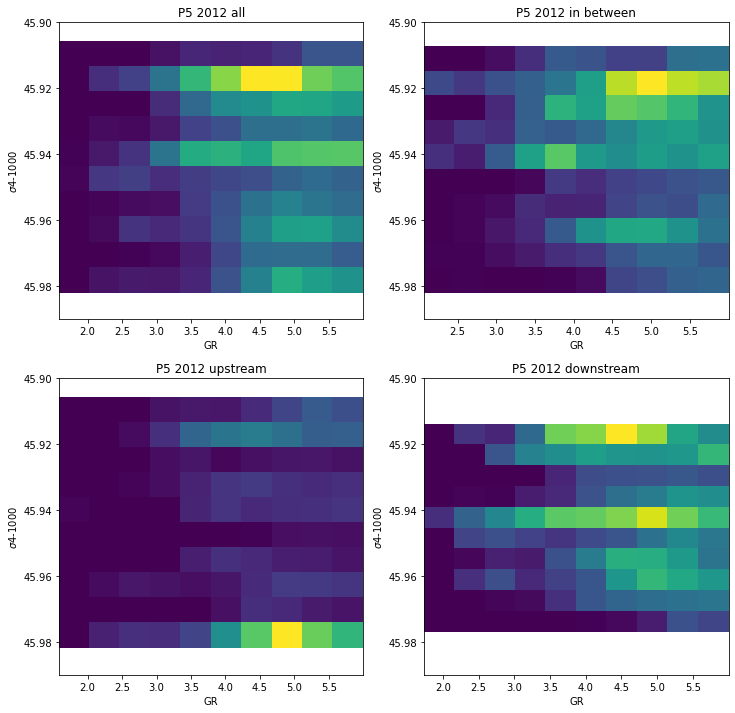

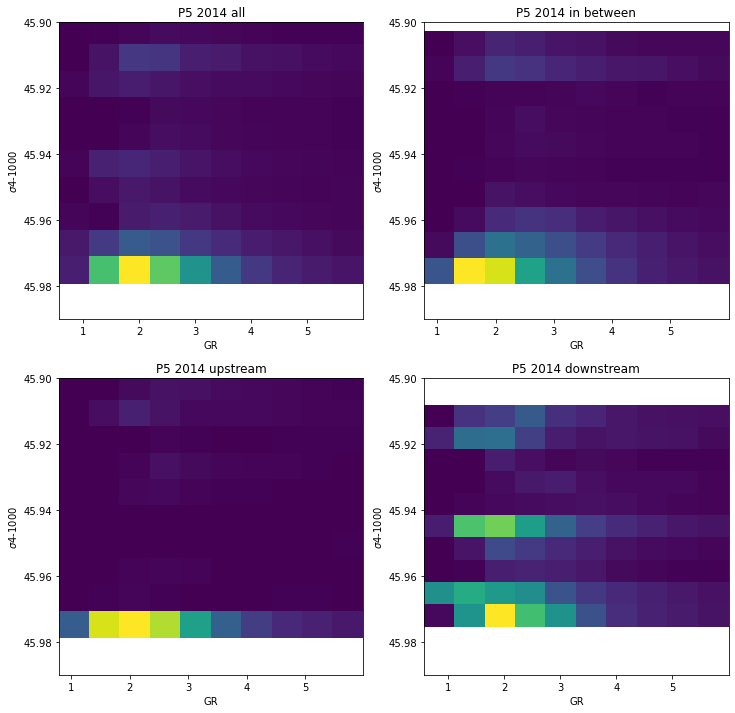

In [16]:
# 2012
fig, ax =  plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

nans = np.isnan(CL_2012_sig4.flatten())
ax[0,0].hist2d(GR_2012.flatten()[~nans],CL_2012_sig4.flatten()[~nans]-1000)
ax[0,0].set_title('P5 2012 all'); ax[0,0].set_xlabel('GR'); ax[0,0].set_ylabel('$\sigma$4-1000'); ax[0,0].set_ylim(45.99,45.9) 

nans = np.isnan(CL_2012_sig4[(FGM_towyo_2012.LAT<-8.1)*(FGM_towyo_2012.LAT>-8.2),:,:].flatten())
ax[0,1].hist2d(GR_2012[(FGM_towyo_2012.LAT<-8.1)*(FGM_towyo_2012.LAT>-8.2),:,:].flatten()[~nans],CL_2012_sig4[(FGM_towyo_2012.LAT<-8.1)*(FGM_towyo_2012.LAT>-8.2),:,:].flatten()[~nans]-1000)
ax[0,1].set_title('P5 2012 in between'); ax[0,1].set_xlabel('GR'); ax[0,1].set_ylabel('$\sigma$4-1000'); ax[0,1].set_ylim(45.99,45.9) 

nans = np.isnan(CL_2012_sig4[FGM_towyo_2012.LAT<=-8.2,:,:].flatten())
ax[1,0].hist2d(GR_2012[FGM_towyo_2012.LAT<=-8.2,:,:].flatten()[~nans],CL_2012_sig4[FGM_towyo_2012.LAT<=-8.2,:,:].flatten()[~nans]-1000)
ax[1,0].set_title('P5 2012 upstream'); ax[1,0].set_xlabel('GR'); ax[1,0].set_ylabel('$\sigma$4-1000'); ax[1,0].set_ylim(45.99,45.9) 

nans = np.isnan(CL_2012_sig4[FGM_towyo_2012.LAT>=-8.1,:,:].flatten())
ax[1,1].hist2d(GR_2012[FGM_towyo_2012.LAT>=-8.1,:,:].flatten()[~nans],CL_2012_sig4[FGM_towyo_2012.LAT>=-8.1,:,:].flatten()[~nans]-1000)
ax[1,1].set_title('P5 2012 downstream'); ax[1,1].set_xlabel('GR'); ax[1,1].set_ylabel('$\sigma$4-1000'); ax[1,1].set_ylim(45.99,45.9) 

# 2014
fig, ax =  plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

nans = np.isnan(CL_2014_sig4.flatten())
ax[0,0].hist2d(GR_2014.flatten()[~nans],CL_2014_sig4.flatten()[~nans]-1000)
ax[0,0].set_title('P5 2014 all'); ax[0,0].set_xlabel('GR'); ax[0,0].set_ylabel('$\sigma$4-1000'); ax[0,0].set_ylim(45.99,45.9) 

nans = np.isnan(CL_2014_sig4[(FGM_towyo_2014.LAT<-8.1)*(FGM_towyo_2014.LAT>-8.2),:,:].flatten())
ax[0,1].hist2d(GR_2014[(FGM_towyo_2014.LAT<-8.1)*(FGM_towyo_2014.LAT>-8.2),:,:].flatten()[~nans],CL_2014_sig4[(FGM_towyo_2014.LAT<-8.1)*(FGM_towyo_2014.LAT>-8.2),:,:].flatten()[~nans]-1000)
ax[0,1].set_title('P5 2014 in between'); ax[0,1].set_xlabel('GR'); ax[0,1].set_ylabel('$\sigma$4-1000'); ax[0,1].set_ylim(45.99,45.9) 

nans = np.isnan(CL_2014_sig4[FGM_towyo_2014.LAT<=-8.2,:,:].flatten())
ax[1,0].hist2d(GR_2014[FGM_towyo_2014.LAT<=-8.2,:,:].flatten()[~nans],CL_2014_sig4[FGM_towyo_2014.LAT<=-8.2,:,:].flatten()[~nans]-1000)
ax[1,0].set_title('P5 2014 upstream'); ax[1,0].set_xlabel('GR'); ax[1,0].set_ylabel('$\sigma$4-1000'); ax[1,0].set_ylim(45.99,45.9) 

nans = np.isnan(CL_2014_sig4[FGM_towyo_2014.LAT>=-8.1,:,:].flatten())
ax[1,1].hist2d(GR_2014[FGM_towyo_2014.LAT>=-8.1,:,:].flatten()[~nans],CL_2014_sig4[FGM_towyo_2014.LAT>=-8.1,:,:].flatten()[~nans]-1000)
ax[1,1].set_title('P5 2014 downstream'); ax[1,1].set_xlabel('GR'); ax[1,1].set_ylabel('$\sigma$4-1000'); ax[1,1].set_ylim(45.99,45.9) 


b) ex2 (FG method, inviscid background flow)

In [17]:
GM_towyo_2012 = sio.loadmat(mdirec+'codes/'+'P5_00_2012_ex2.mat',squeeze_me = True,struct_as_record = False)
GR_2012=2*np.pi/GM_towyo_2012['GR_all']/3600
CL_2012=GM_towyo_2012['CL_all']
ERR_K_2012=GM_towyo_2012['ERR_K_all']
ERR_B_2012=GM_towyo_2012['ERR_B_all']

GM_towyo_2014 = sio.loadmat(mdirec+'codes/'+'P5_02_2014_ex2.mat',squeeze_me = True,struct_as_record = False)
GR_2014=2*np.pi/GM_towyo_2014['GR_all']/3600
CL_2014=GM_towyo_2014['CL_all']
ERR_K_2014=GM_towyo_2014['ERR_K_all']
ERR_B_2014=GM_towyo_2014['ERR_B_all']

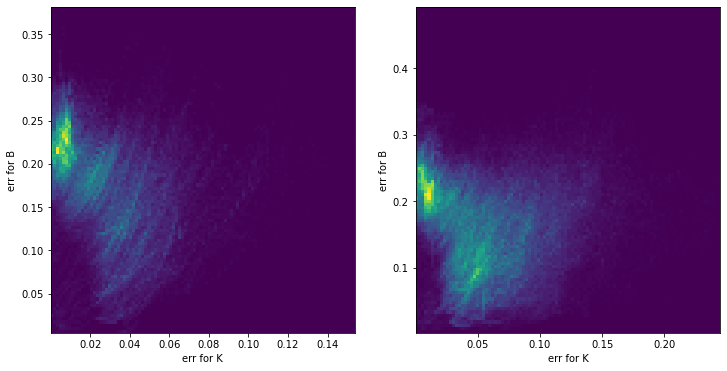

In [18]:
# check for errors
fig, ax =  plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
nans = np.isnan(CL_2012.flatten())
ax[0].hist2d(ERR_K_2012.flatten()[~nans],ERR_B_2012.flatten()[~nans], bins=100)
ax[0].set_xlabel('err for K'); ax[0].set_ylabel('err for B'); 

nans = np.isnan(CL_2014.flatten())
ax[1].hist2d(ERR_K_2014.flatten()[~nans],ERR_B_2014.flatten()[~nans], bins=100)
ax[1].set_xlabel('err for K'); ax[1].set_ylabel('err for B'); 


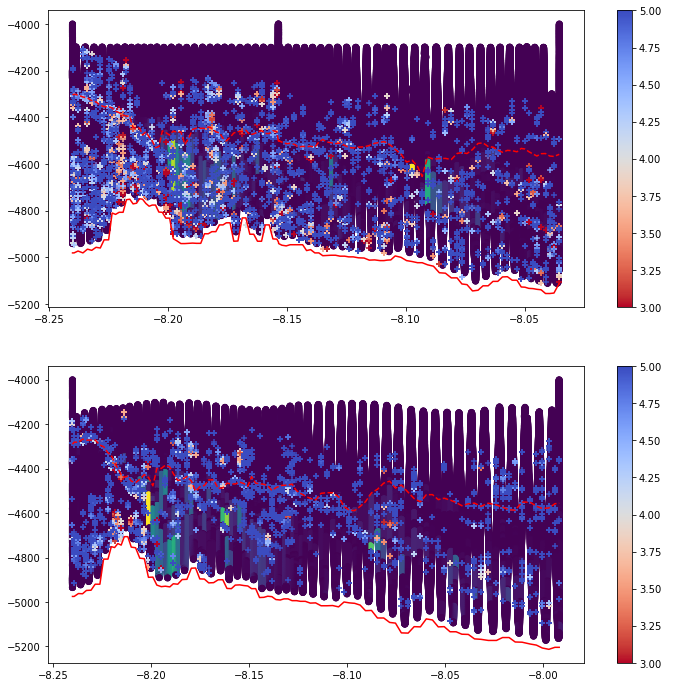

In [19]:
# critical level, GR along path
fig, ax =  plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
ax[0].scatter(data_2014['lat'],data_2014['z'],c=data_2014['eps']) #c=np.log10(data_ex2['eps']))
ax[0].plot(FGM_towyo_2014.LAT, FGM_towyo_2014.bdepth, 'r-', label='sea bottom')
ax[0].plot(FGM_towyo_2014.LAT, FGM_towyo_2014.zo, 'r--', label='interface')
for i in range(len(FGM_towyo_2014.LAT)):  
    mask = np.isnan(CL_2014[i,:,:].flatten())
    sc = ax[0].scatter(np.ones(len(CL_2014[i,:,:].flatten()[~mask]))*FGM_towyo_2014.LAT[i].data, CL_2014[i,:,:].flatten()[~mask],  c=GR_2014[i,:,:].flatten()[~mask], vmax=5, vmin=3, marker='+', cmap=cm.coolwarm_r)
fig.colorbar(sc,label=" ",ax=ax[0])

ax[1].scatter(data_2012['lat'],data_2012['z'],c=data_2012['eps']) #c=np.log10(data_ex2['eps']))
ax[1].plot(FGM_towyo_2012.LAT, FGM_towyo_2012.bdepth, 'r-', label='sea bottom')
ax[1].plot(FGM_towyo_2012.LAT, FGM_towyo_2012.zo, 'r--', label='interface')
for i in range(len(FGM_towyo_2012.LAT)):  
    mask = np.isnan(CL_2012[i,:,:].flatten())
    sc = ax[1].scatter(np.ones(len(CL_2012[i,:,:].flatten()[~mask]))*FGM_towyo_2012.LAT[i].data, CL_2012[i,:,:].flatten()[~mask],  c=GR_2012[i,:,:].flatten()[~mask], vmax=5, vmin=3, marker='+', cmap=cm.coolwarm_r)
fig.colorbar(sc,label=" ",ax=ax[1])


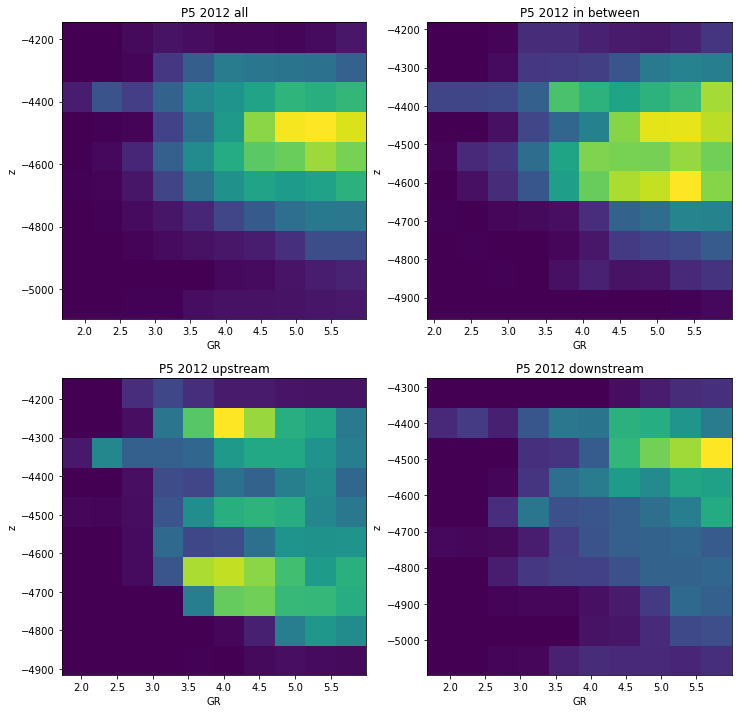

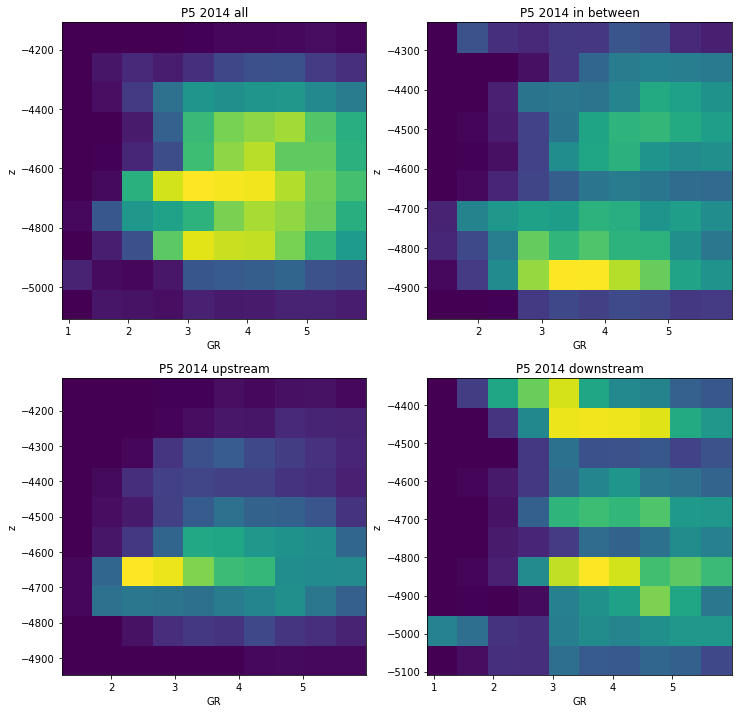

In [20]:
# critical layer & GR statistics

# 2012
fig, ax =  plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

nans = np.isnan(CL_2012.flatten())
ax[0,0].hist2d(GR_2012.flatten()[~nans],CL_2012.flatten()[~nans])
ax[0,0].set_title('P5 2012 all'); ax[0,0].set_xlabel('GR'); ax[0,0].set_ylabel('z'); 

nans = np.isnan(CL_2012[(FGM_towyo_2012.LAT<-8.1)*(FGM_towyo_2012.LAT>-8.2),:,:].flatten())
ax[0,1].hist2d(GR_2012[(FGM_towyo_2012.LAT<-8.1)*(FGM_towyo_2012.LAT>-8.2),:,:].flatten()[~nans],CL_2012[(FGM_towyo_2012.LAT<-8.1)*(FGM_towyo_2012.LAT>-8.2),:,:].flatten()[~nans])
ax[0,1].set_title('P5 2012 in between'); ax[0,1].set_xlabel('GR'); ax[0,1].set_ylabel('z'); 

nans = np.isnan(CL_2012[FGM_towyo_2012.LAT<=-8.2,:,:].flatten())
ax[1,0].hist2d(GR_2012[FGM_towyo_2012.LAT<=-8.2,:,:].flatten()[~nans],CL_2012[FGM_towyo_2012.LAT<=-8.2,:,:].flatten()[~nans])
ax[1,0].set_title('P5 2012 upstream'); ax[1,0].set_xlabel('GR'); ax[1,0].set_ylabel('z'); 

nans = np.isnan(CL_2012[FGM_towyo_2012.LAT>=-8.1,:,:].flatten())
ax[1,1].hist2d(GR_2012[FGM_towyo_2012.LAT>=-8.1,:,:].flatten()[~nans],CL_2012[FGM_towyo_2012.LAT>=-8.1,:,:].flatten()[~nans])
ax[1,1].set_title('P5 2012 downstream'); ax[1,1].set_xlabel('GR'); ax[1,1].set_ylabel('z'); 

# 2014
fig, ax =  plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

nans = np.isnan(CL_2014.flatten())
ax[0,0].hist2d(GR_2014.flatten()[~nans],CL_2014.flatten()[~nans])
ax[0,0].set_title('P5 2014 all'); ax[0,0].set_xlabel('GR'); ax[0,0].set_ylabel('z'); 

nans = np.isnan(CL_2014[(FGM_towyo_2014.LAT<-8.1)*(FGM_towyo_2014.LAT>-8.2),:,:].flatten())
ax[0,1].hist2d(GR_2014[(FGM_towyo_2014.LAT<-8.1)*(FGM_towyo_2014.LAT>-8.2),:,:].flatten()[~nans],CL_2014[(FGM_towyo_2014.LAT<-8.1)*(FGM_towyo_2014.LAT>-8.2),:,:].flatten()[~nans])
ax[0,1].set_title('P5 2014 in between'); ax[0,1].set_xlabel('GR'); ax[0,1].set_ylabel('z'); 

nans = np.isnan(CL_2014[FGM_towyo_2014.LAT<=-8.2,:,:].flatten())
ax[1,0].hist2d(GR_2014[FGM_towyo_2014.LAT<=-8.2,:,:].flatten()[~nans],CL_2014[FGM_towyo_2014.LAT<=-8.2,:,:].flatten()[~nans])
ax[1,0].set_title('P5 2014 upstream'); ax[1,0].set_xlabel('GR'); ax[1,0].set_ylabel('z'); 

nans = np.isnan(CL_2014[FGM_towyo_2014.LAT>=-8.1,:,:].flatten())
ax[1,1].hist2d(GR_2014[FGM_towyo_2014.LAT>=-8.1,:,:].flatten()[~nans],CL_2014[FGM_towyo_2014.LAT>=-8.1,:,:].flatten()[~nans])
ax[1,1].set_title('P5 2014 downstream'); ax[1,1].set_xlabel('GR'); ax[1,1].set_ylabel('z'); 



In [21]:
# GR vs sig4_sorted
CL_2012_sig4 = np.zeros(CL_2012.shape) + np.nan
for i in range(len(FGM_towyo_2012.LAT)):  
    f=interp1d(data_2012['z'][:,i],data_2012['sig4_sorted'][:,i])
    CL_2012_sig4[i,:,:] = f(CL_2012[i,:,:])

CL_2014_sig4 = np.zeros(CL_2014.shape) + np.nan
for i in range(len(FGM_towyo_2014.LAT)):  
    f=interp1d(data_2014['z'][:,i],data_2014['sig4_sorted'][:,i])
    CL_2014_sig4[i,:,:] = f(CL_2014[i,:,:])


(45.99, 45.9)

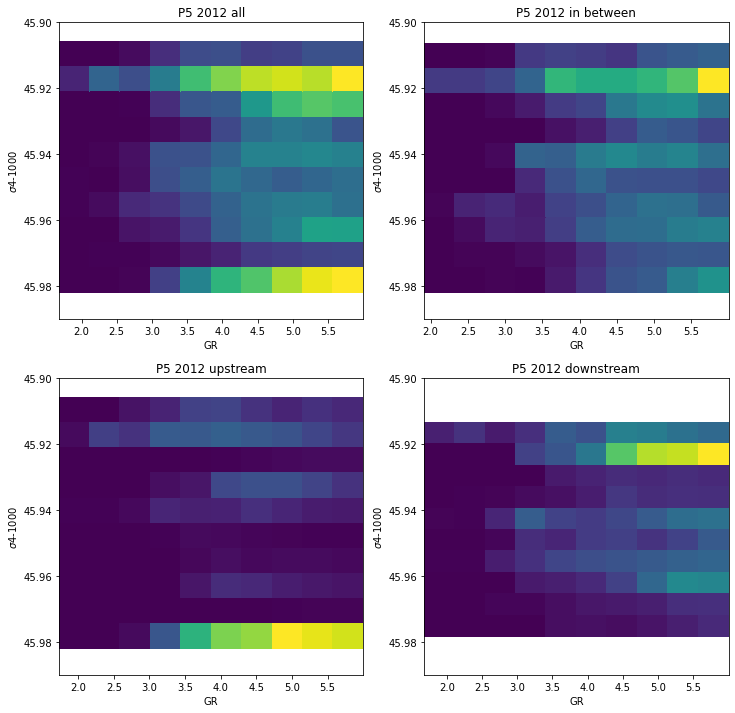

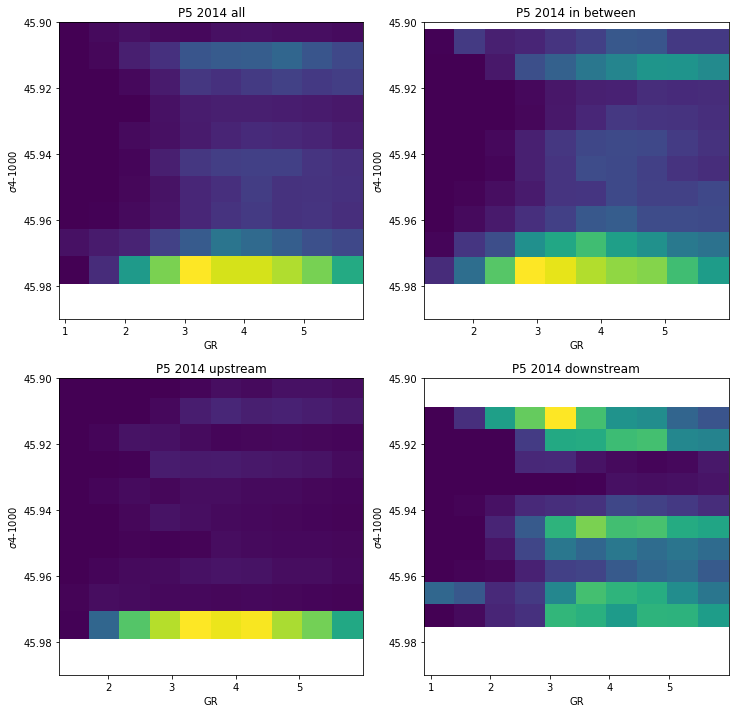

In [22]:
# 2012
fig, ax =  plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

nans = np.isnan(CL_2012_sig4.flatten())
ax[0,0].hist2d(GR_2012.flatten()[~nans],CL_2012_sig4.flatten()[~nans]-1000)
ax[0,0].set_title('P5 2012 all'); ax[0,0].set_xlabel('GR'); ax[0,0].set_ylabel('$\sigma$4-1000'); ax[0,0].set_ylim(45.99,45.9) 

nans = np.isnan(CL_2012_sig4[(FGM_towyo_2012.LAT<-8.1)*(FGM_towyo_2012.LAT>-8.2),:,:].flatten())
ax[0,1].hist2d(GR_2012[(FGM_towyo_2012.LAT<-8.1)*(FGM_towyo_2012.LAT>-8.2),:,:].flatten()[~nans],CL_2012_sig4[(FGM_towyo_2012.LAT<-8.1)*(FGM_towyo_2012.LAT>-8.2),:,:].flatten()[~nans]-1000)
ax[0,1].set_title('P5 2012 in between'); ax[0,1].set_xlabel('GR'); ax[0,1].set_ylabel('$\sigma$4-1000'); ax[0,1].set_ylim(45.99,45.9) 

nans = np.isnan(CL_2012_sig4[FGM_towyo_2012.LAT<=-8.2,:,:].flatten())
ax[1,0].hist2d(GR_2012[FGM_towyo_2012.LAT<=-8.2,:,:].flatten()[~nans],CL_2012_sig4[FGM_towyo_2012.LAT<=-8.2,:,:].flatten()[~nans]-1000)
ax[1,0].set_title('P5 2012 upstream'); ax[1,0].set_xlabel('GR'); ax[1,0].set_ylabel('$\sigma$4-1000'); ax[1,0].set_ylim(45.99,45.9) 

nans = np.isnan(CL_2012_sig4[FGM_towyo_2012.LAT>=-8.1,:,:].flatten())
ax[1,1].hist2d(GR_2012[FGM_towyo_2012.LAT>=-8.1,:,:].flatten()[~nans],CL_2012_sig4[FGM_towyo_2012.LAT>=-8.1,:,:].flatten()[~nans]-1000)
ax[1,1].set_title('P5 2012 downstream'); ax[1,1].set_xlabel('GR'); ax[1,1].set_ylabel('$\sigma$4-1000'); ax[1,1].set_ylim(45.99,45.9) 

# 2014
fig, ax =  plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

nans = np.isnan(CL_2014_sig4.flatten())
ax[0,0].hist2d(GR_2014.flatten()[~nans],CL_2014_sig4.flatten()[~nans]-1000)
ax[0,0].set_title('P5 2014 all'); ax[0,0].set_xlabel('GR'); ax[0,0].set_ylabel('$\sigma$4-1000'); ax[0,0].set_ylim(45.99,45.9) 

nans = np.isnan(CL_2014_sig4[(FGM_towyo_2014.LAT<-8.1)*(FGM_towyo_2014.LAT>-8.2),:,:].flatten())
ax[0,1].hist2d(GR_2014[(FGM_towyo_2014.LAT<-8.1)*(FGM_towyo_2014.LAT>-8.2),:,:].flatten()[~nans],CL_2014_sig4[(FGM_towyo_2014.LAT<-8.1)*(FGM_towyo_2014.LAT>-8.2),:,:].flatten()[~nans]-1000)
ax[0,1].set_title('P5 2014 in between'); ax[0,1].set_xlabel('GR'); ax[0,1].set_ylabel('$\sigma$4-1000'); ax[0,1].set_ylim(45.99,45.9) 

nans = np.isnan(CL_2014_sig4[FGM_towyo_2014.LAT<=-8.2,:,:].flatten())
ax[1,0].hist2d(GR_2014[FGM_towyo_2014.LAT<=-8.2,:,:].flatten()[~nans],CL_2014_sig4[FGM_towyo_2014.LAT<=-8.2,:,:].flatten()[~nans]-1000)
ax[1,0].set_title('P5 2014 upstream'); ax[1,0].set_xlabel('GR'); ax[1,0].set_ylabel('$\sigma$4-1000'); ax[1,0].set_ylim(45.99,45.9) 

nans = np.isnan(CL_2014_sig4[FGM_towyo_2014.LAT>=-8.1,:,:].flatten())
ax[1,1].hist2d(GR_2014[FGM_towyo_2014.LAT>=-8.1,:,:].flatten()[~nans],CL_2014_sig4[FGM_towyo_2014.LAT>=-8.1,:,:].flatten()[~nans]-1000)
ax[1,1].set_title('P5 2014 downstream'); ax[1,1].set_xlabel('GR'); ax[1,1].set_ylabel('$\sigma$4-1000'); ax[1,1].set_ylim(45.99,45.9) 


(array([69575.,  9935.,  5100.,  3602.,  3346.,  2253.,   938.,  1289.,
         1026.,   225.]),
 array([  0.        ,  10.29769769,  20.59539539,  30.89309308,
         41.19079077,  51.48848847,  61.78618616,  72.08388385,
         82.38158154,  92.67927924, 102.97697693]),
 <BarContainer object of 10 artists>)

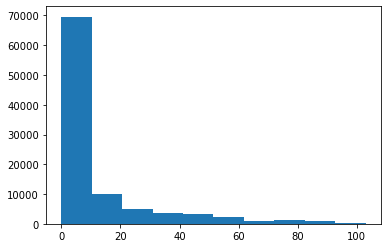

In [23]:
plt.hist(data_2014['LT'].flatten())

(array([58062., 10560.,  5178.,  3025.,  2445.,  1262.,   509.,   606.,
          222.,   738.]),
 array([  0.        ,  10.40895162,  20.81790323,  31.22685485,
         41.63580647,  52.04475808,  62.4537097 ,  72.86266132,
         83.27161294,  93.68056455, 104.08951617]),
 <BarContainer object of 10 artists>)

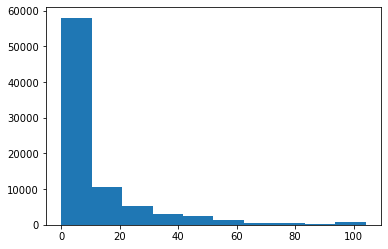

In [24]:
plt.hist(data_2012['LT'].flatten())

In [25]:
np.nanpercentile(data_2012['LT'].flatten(),85)

23.400979454203586

c) ex4 (FD method, velocity profile low-pass filtered using 40-m butterworth window, viscous background flow)

In [39]:
GM_towyo_2012 = sio.loadmat(mdirec+'codes/'+'TG_SI_TY_P5_00_2012_ex4.mat',squeeze_me = True,struct_as_record = False)
GR_2012=2*np.pi/GM_towyo_2012['GR_all']/3600
CL_2012=GM_towyo_2012['CL_all']
ERR_K_2012=GM_towyo_2012['ERR_K_all']
ERR_B_2012=GM_towyo_2012['ERR_B_all']

GM_towyo_2014 = sio.loadmat(mdirec+'codes/'+'TG_SI_TY_P5_02_2014_ex4.mat',squeeze_me = True,struct_as_record = False)
GR_2014=2*np.pi/GM_towyo_2014['GR_all']/3600
CL_2014=GM_towyo_2014['CL_all']
ERR_K_2014=GM_towyo_2014['ERR_K_all']
ERR_B_2014=GM_towyo_2014['ERR_B_all']


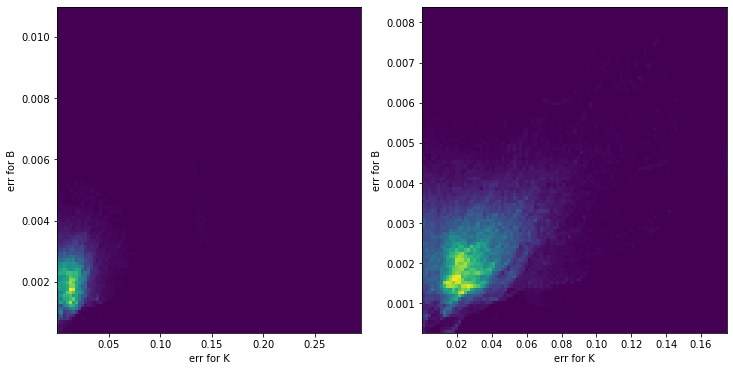

In [40]:
# check for errors
fig, ax =  plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].hist2d(ERR_K_2012.flatten()[(GR_2012.flatten()<=6)*(GR_2012.flatten()>=0)],ERR_B_2012.flatten()[(GR_2012.flatten()<=6)*(GR_2012.flatten()>=0)], bins=100)
ax[0].set_xlabel('err for K'); ax[0].set_ylabel('err for B'); 

ax[1].hist2d(ERR_K_2014.flatten()[(GR_2014.flatten()<=6)*(GR_2014.flatten()>=0)],ERR_B_2014.flatten()[(GR_2014.flatten()<=6)*(GR_2014.flatten()>=0)], bins=100)
ax[1].set_xlabel('err for K'); ax[1].set_ylabel('err for B'); 


Text(0.5, 1.0, 'P5 2012')

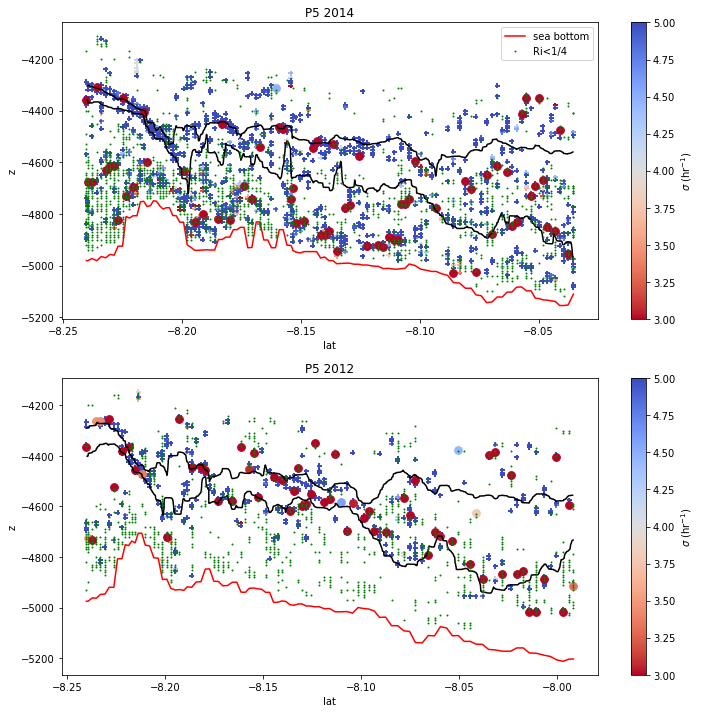

In [41]:
# critical level, GR along path
fig, ax =  plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
# ax[0].scatter(data_2014['lat'],data_2014['z'],c=data_2014['eps']) #c=np.log10(data_ex2['eps']))
ax[0].plot(FGM_towyo_2014.LAT, FGM_towyo_2014.bdepth, 'r-', label='sea bottom')
# ax[0].plot(FGM_towyo_2014.LAT, FGM_towyo_2014.zo, 'r--', label='interface')
ax[0].contour(data_2014['lat'],data_2014['z'],data_2014['sig4_sorted'],[1045.93, 1045.96],colors='k')
for i in range(len(GM_towyo_2014['LAT'])):  
    mask = GM_towyo_2014['Ri'][:,i]<1/4
    ax[0].plot(np.ones((len(GM_towyo_2014['zw'][mask])))*GM_towyo_2014['LAT'][i], GM_towyo_2014['zw'][mask], 'g.', ms=2)
ax[0].plot(np.ones((len(GM_towyo_2014['zw'][mask])))*GM_towyo_2014['LAT'][i], GM_towyo_2014['zw'][mask], 'g.', ms=2, label='Ri<1/4')
for i in range(len(GM_towyo_2014['LAT'])):  
    sc = ax[0].scatter(np.ones(len(CL_2014[i,:,:].flatten()[(GR_2014[i,:,:].flatten()<=6)*(GR_2014[i,:,:].flatten()>=0)]))*GM_towyo_2014['LAT'][i], CL_2014[i,:,:].flatten()[(GR_2014[i,:,:].flatten()<=6)*(GR_2014[i,:,:].flatten()>=0)],  c=GR_2014[i,:,:].flatten()[(GR_2014[i,:,:].flatten()<=6)*(GR_2014[i,:,:].flatten()>=0)], vmax=5, vmin=3, marker='+', s=25, cmap=cm.coolwarm_r)
for i in range(len(GM_towyo_2014['LAT'])):  
    if (np.min(GR_2014[i,:,:].flatten())<=6)*(np.min(GR_2014[i,:,:].flatten())>=0):
        ax[0].scatter(GM_towyo_2014['LAT'][i], CL_2014[i,:,:].flatten()[np.argmin(GR_2014[i,:,:].flatten())],  c=np.min(GR_2014[i,:,:].flatten()), vmax=6, vmin=5, marker='o', s=60, cmap=cm.coolwarm_r)
fig.colorbar(sc,label="$\sigma$ (hr$^{-1}$)",ax=ax[0])
ax[0].legend()
ax[0].set_xlabel('lat'); ax[0].set_ylabel('z'); ax[0].set_title('P5 2014')

# ax[1].scatter(data_2012['lat'],data_2012['z'],c=data_2012['eps']) #c=np.log10(data_ex2['eps']))
ax[1].plot(FGM_towyo_2012.LAT, FGM_towyo_2012.bdepth, 'r-', label='sea bottom')
# ax[1].plot(FGM_towyo_2012.LAT, FGM_towyo_2012.zo, 'r--', label='interface')
ax[1].contour(data_2012['lat'],data_2012['z'],data_2012['sig4_sorted'],[1045.93, 1045.96],colors='k')
for i in range(len(GM_towyo_2012['LAT'])):  
    mask = GM_towyo_2012['Ri'][:,i]<1/4
    ax[1].plot(np.ones((len(GM_towyo_2012['zw'][mask])))*GM_towyo_2012['LAT'][i], GM_towyo_2012['zw'][mask], 'g.', ms=2)
for i in range(len(GM_towyo_2012['LAT'])):  
    sc = ax[1].scatter(np.ones(len(CL_2012[i,:,:].flatten()[(GR_2012[i,:,:].flatten()<=6)*(GR_2012[i,:,:].flatten()>=0)]))*FGM_towyo_2012.LAT[i].data, CL_2012[i,:,:].flatten()[(GR_2012[i,:,:].flatten()<=6)*(GR_2012[i,:,:].flatten()>=0)],  c=GR_2012[i,:,:].flatten()[(GR_2012[i,:,:].flatten()<=6)*(GR_2012[i,:,:].flatten()>=0)], vmax=5, vmin=3, marker='+', s=25, cmap=cm.coolwarm_r)
for i in range(len(GM_towyo_2012['LAT'])):  
    if (np.min(GR_2012[i,:,:].flatten())<=6)*(np.min(GR_2012[i,:,:].flatten())>=0):
        ax[1].scatter(GM_towyo_2012['LAT'][i], CL_2012[i,:,:].flatten()[np.argmin(GR_2012[i,:,:].flatten())],  c=np.min(GR_2012[i,:,:].flatten()), vmax=6, vmin=5, marker='o', s=60, cmap=cm.coolwarm_r)
fig.colorbar(sc,label="$\sigma$ (hr$^{-1}$)",ax=ax[1])
ax[1].set_xlabel('lat'); ax[1].set_ylabel('z'); ax[1].set_title('P5 2012')

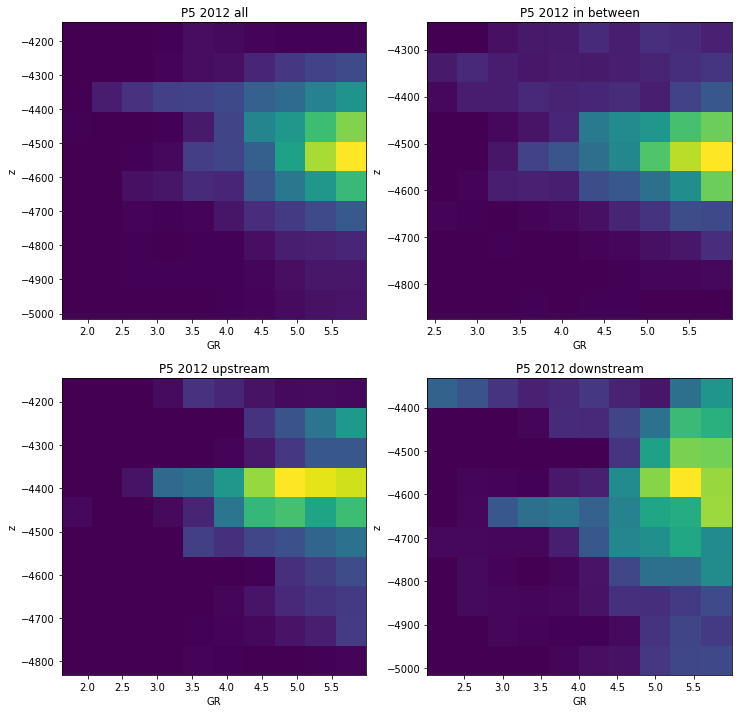

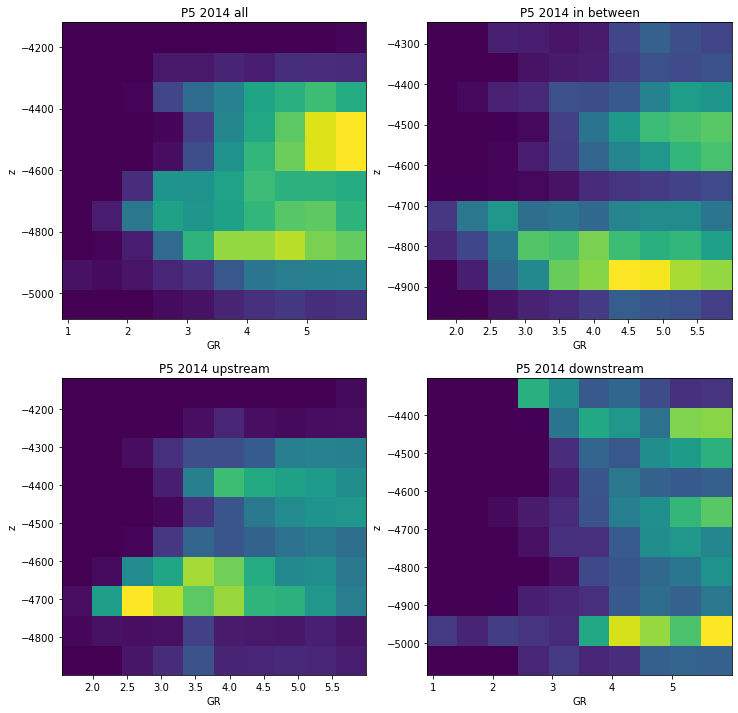

In [29]:
# 2012
fig, ax =  plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

nans = (GR_2012.flatten()<=6)*(GR_2012.flatten()>=0)
ax[0,0].hist2d(GR_2012.flatten()[nans],CL_2012.flatten()[nans])
ax[0,0].set_title('P5 2012 all'); ax[0,0].set_xlabel('GR'); ax[0,0].set_ylabel('z'); 

nans = (GR_2012[(FGM_towyo_2012.LAT<-8.1)*(FGM_towyo_2012.LAT>-8.2),:,:].flatten()<=6)*(GR_2012[(FGM_towyo_2012.LAT<-8.1)*(FGM_towyo_2012.LAT>-8.2),:,:].flatten()>=0)
ax[0,1].hist2d(GR_2012[(FGM_towyo_2012.LAT<-8.1)*(FGM_towyo_2012.LAT>-8.2),:,:].flatten()[nans],CL_2012[(FGM_towyo_2012.LAT<-8.1)*(FGM_towyo_2012.LAT>-8.2),:,:].flatten()[nans])
ax[0,1].set_title('P5 2012 in between'); ax[0,1].set_xlabel('GR'); ax[0,1].set_ylabel('z'); 

nans = (GR_2012[FGM_towyo_2012.LAT<=-8.2,:,:].flatten()<=6)*(GR_2012[FGM_towyo_2012.LAT<=-8.2,:,:].flatten()>=0)
ax[1,0].hist2d(GR_2012[FGM_towyo_2012.LAT<=-8.2,:,:].flatten()[nans],CL_2012[FGM_towyo_2012.LAT<=-8.2,:,:].flatten()[nans])
ax[1,0].set_title('P5 2012 upstream'); ax[1,0].set_xlabel('GR'); ax[1,0].set_ylabel('z'); 

nans = (GR_2012[FGM_towyo_2012.LAT>=-8.1,:,:].flatten()<=6)*(GR_2012[FGM_towyo_2012.LAT>=-8.1,:,:].flatten()>=0)
ax[1,1].hist2d(GR_2012[FGM_towyo_2012.LAT>=-8.1,:,:].flatten()[nans],CL_2012[FGM_towyo_2012.LAT>=-8.1,:,:].flatten()[nans])
ax[1,1].set_title('P5 2012 downstream'); ax[1,1].set_xlabel('GR'); ax[1,1].set_ylabel('z'); 



# 2014
fig, ax =  plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

nans = (GR_2014.flatten()<=6)*(GR_2014.flatten()>=0)
ax[0,0].hist2d(GR_2014.flatten()[nans],CL_2014.flatten()[nans])
ax[0,0].set_title('P5 2014 all'); ax[0,0].set_xlabel('GR'); ax[0,0].set_ylabel('z'); 

nans = (GR_2014[(FGM_towyo_2014.LAT<-8.1)*(FGM_towyo_2014.LAT>-8.2),:,:].flatten()<=6)*(GR_2014[(FGM_towyo_2014.LAT<-8.1)*(FGM_towyo_2014.LAT>-8.2),:,:].flatten()>=0)
ax[0,1].hist2d(GR_2014[(FGM_towyo_2014.LAT<-8.1)*(FGM_towyo_2014.LAT>-8.2),:,:].flatten()[nans],CL_2014[(FGM_towyo_2014.LAT<-8.1)*(FGM_towyo_2014.LAT>-8.2),:,:].flatten()[nans])
ax[0,1].set_title('P5 2014 in between'); ax[0,1].set_xlabel('GR'); ax[0,1].set_ylabel('z'); 

nans = (GR_2014[FGM_towyo_2014.LAT<=-8.2,:,:].flatten()<=6)*(GR_2014[FGM_towyo_2014.LAT<=-8.2,:,:].flatten()>=0)
ax[1,0].hist2d(GR_2014[FGM_towyo_2014.LAT<=-8.2,:,:].flatten()[nans],CL_2014[FGM_towyo_2014.LAT<=-8.2,:,:].flatten()[nans])
ax[1,0].set_title('P5 2014 upstream'); ax[1,0].set_xlabel('GR'); ax[1,0].set_ylabel('z'); 

nans = (GR_2014[FGM_towyo_2014.LAT>=-8.1,:,:].flatten()<=6)*(GR_2014[FGM_towyo_2014.LAT>=-8.1,:,:].flatten()>=0)
ax[1,1].hist2d(GR_2014[FGM_towyo_2014.LAT>=-8.1,:,:].flatten()[nans],CL_2014[FGM_towyo_2014.LAT>=-8.1,:,:].flatten()[nans])
ax[1,1].set_title('P5 2014 downstream'); ax[1,1].set_xlabel('GR'); ax[1,1].set_ylabel('z'); 



In [30]:
# GR vs sig4_sorted
CL_2012_sig4 = np.zeros(CL_2012.shape) + np.nan
for i in range(len(FGM_towyo_2012.LAT)):  
    f=interp1d(data_2012['z'][:,i],data_2012['sig4_sorted'][:,i])
    CL_2012_sig4[i,:,:] = f(CL_2012[i,:,:])

CL_2014_sig4 = np.zeros(CL_2014.shape) + np.nan
for i in range(len(FGM_towyo_2014.LAT)):  
    f=interp1d(data_2014['z'][:,i],data_2014['sig4_sorted'][:,i])
    CL_2014_sig4[i,:,:] = f(CL_2014[i,:,:])


(45.99, 45.9)

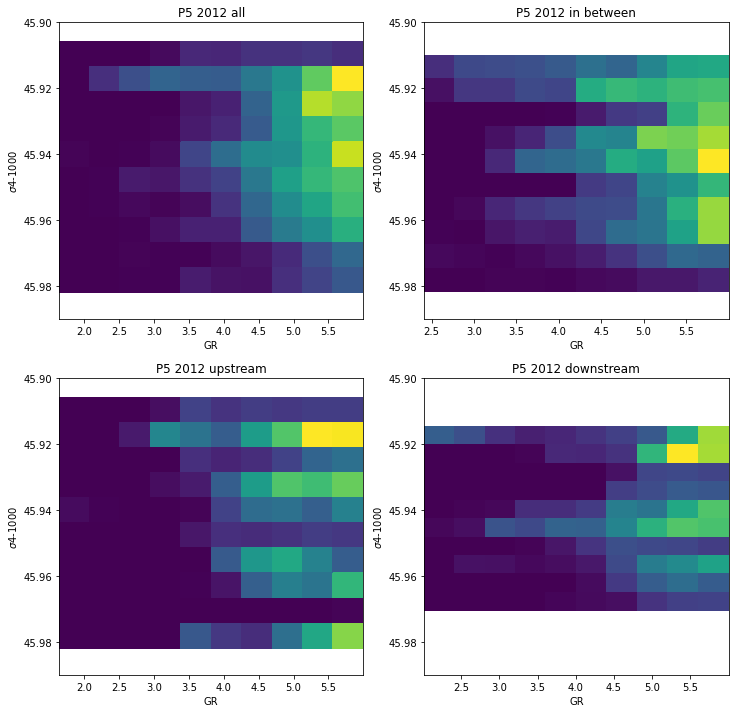

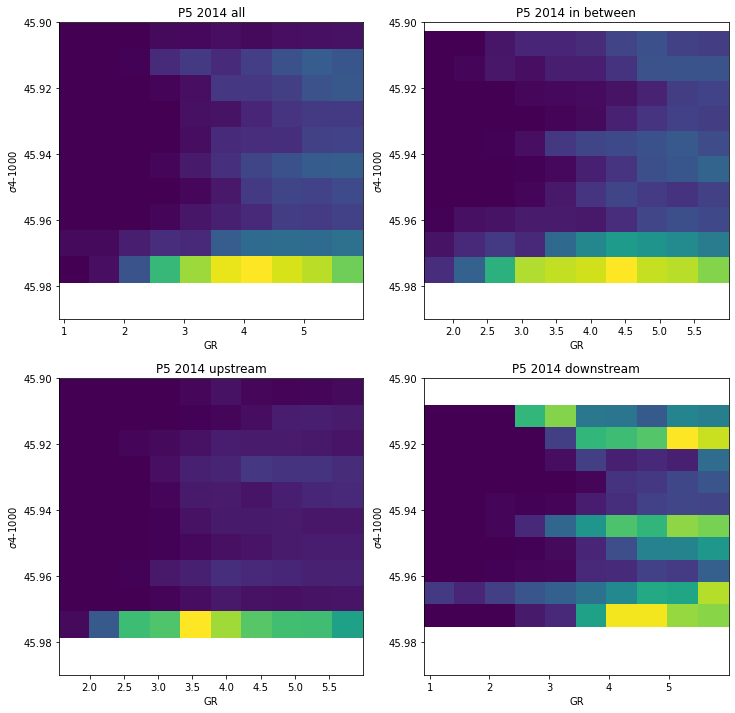

In [31]:
# 2012
fig, ax =  plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

nans = (GR_2012.flatten()<=6)*(GR_2012.flatten()>=0)
ax[0,0].hist2d(GR_2012.flatten()[nans],CL_2012_sig4.flatten()[nans]-1000)
ax[0,0].set_title('P5 2012 all'); ax[0,0].set_xlabel('GR'); ax[0,0].set_ylabel('$\sigma$4-1000'); ax[0,0].set_ylim(45.99,45.9) 

nans = (GR_2012[(FGM_towyo_2012.LAT<-8.1)*(FGM_towyo_2012.LAT>-8.2),:,:].flatten()<=6)*(GR_2012[(FGM_towyo_2012.LAT<-8.1)*(FGM_towyo_2012.LAT>-8.2),:,:].flatten()>=0)
ax[0,1].hist2d(GR_2012[(FGM_towyo_2012.LAT<-8.1)*(FGM_towyo_2012.LAT>-8.2),:,:].flatten()[nans],CL_2012_sig4[(FGM_towyo_2012.LAT<-8.1)*(FGM_towyo_2012.LAT>-8.2),:,:].flatten()[nans]-1000)
ax[0,1].set_title('P5 2012 in between'); ax[0,1].set_xlabel('GR'); ax[0,1].set_ylabel('$\sigma$4-1000'); ax[0,1].set_ylim(45.99,45.9) 

nans = (GR_2012[FGM_towyo_2012.LAT<=-8.2,:,:].flatten()<=6)*(GR_2012[FGM_towyo_2012.LAT<=-8.2,:,:].flatten()>=0)
ax[1,0].hist2d(GR_2012[FGM_towyo_2012.LAT<=-8.2,:,:].flatten()[nans],CL_2012_sig4[FGM_towyo_2012.LAT<=-8.2,:,:].flatten()[nans]-1000)
ax[1,0].set_title('P5 2012 upstream'); ax[1,0].set_xlabel('GR'); ax[1,0].set_ylabel('$\sigma$4-1000'); ax[1,0].set_ylim(45.99,45.9) 

nans = (GR_2012[FGM_towyo_2012.LAT>=-8.1,:,:].flatten()<=6)*(GR_2012[FGM_towyo_2012.LAT>=-8.1,:,:].flatten()>=0)
ax[1,1].hist2d(GR_2012[FGM_towyo_2012.LAT>=-8.1,:,:].flatten()[nans],CL_2012_sig4[FGM_towyo_2012.LAT>=-8.1,:,:].flatten()[nans]-1000)
ax[1,1].set_title('P5 2012 downstream'); ax[1,1].set_xlabel('GR'); ax[1,1].set_ylabel('$\sigma$4-1000'); ax[1,1].set_ylim(45.99,45.9) 

# 2014
fig, ax =  plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

nans = (~np.isnan(CL_2014_sig4.flatten()))*(GR_2014.flatten()<=6)*(GR_2014.flatten()>=0)
ax[0,0].hist2d(GR_2014.flatten()[nans],CL_2014_sig4.flatten()[nans]-1000)
ax[0,0].set_title('P5 2014 all'); ax[0,0].set_xlabel('GR'); ax[0,0].set_ylabel('$\sigma$4-1000'); ax[0,0].set_ylim(45.99,45.9) 

nans = (~np.isnan(CL_2014_sig4[(FGM_towyo_2014.LAT<-8.1)*(FGM_towyo_2014.LAT>-8.2),:,:].flatten()))*(GR_2014[(FGM_towyo_2014.LAT<-8.1)*(FGM_towyo_2014.LAT>-8.2),:,:].flatten()<=6)*(GR_2014[(FGM_towyo_2014.LAT<-8.1)*(FGM_towyo_2014.LAT>-8.2),:,:].flatten()>=0)
ax[0,1].hist2d(GR_2014[(FGM_towyo_2014.LAT<-8.1)*(FGM_towyo_2014.LAT>-8.2),:,:].flatten()[nans],CL_2014_sig4[(FGM_towyo_2014.LAT<-8.1)*(FGM_towyo_2014.LAT>-8.2),:,:].flatten()[nans]-1000)
ax[0,1].set_title('P5 2014 in between'); ax[0,1].set_xlabel('GR'); ax[0,1].set_ylabel('$\sigma$4-1000'); ax[0,1].set_ylim(45.99,45.9) 

nans = (~np.isnan(CL_2014_sig4[FGM_towyo_2014.LAT<=-8.2,:,:].flatten()))*(GR_2014[FGM_towyo_2014.LAT<=-8.2,:,:].flatten()<=6)*(GR_2014[FGM_towyo_2014.LAT<=-8.2,:,:].flatten()>=0)
ax[1,0].hist2d(GR_2014[FGM_towyo_2014.LAT<=-8.2,:,:].flatten()[nans],CL_2014_sig4[FGM_towyo_2014.LAT<=-8.2,:,:].flatten()[nans]-1000)
ax[1,0].set_title('P5 2014 upstream'); ax[1,0].set_xlabel('GR'); ax[1,0].set_ylabel('$\sigma$4-1000'); ax[1,0].set_ylim(45.99,45.9) 

nans = (~np.isnan(CL_2014_sig4[FGM_towyo_2014.LAT>=-8.1,:,:].flatten()))*(GR_2014[FGM_towyo_2014.LAT>=-8.1,:,:].flatten()<=6)*(GR_2014[FGM_towyo_2014.LAT>=-8.1,:,:].flatten()>=0)
ax[1,1].hist2d(GR_2014[FGM_towyo_2014.LAT>=-8.1,:,:].flatten()[nans],CL_2014_sig4[FGM_towyo_2014.LAT>=-8.1,:,:].flatten()[nans]-1000)
ax[1,1].set_title('P5 2014 downstream'); ax[1,1].set_xlabel('GR'); ax[1,1].set_ylabel('$\sigma$4-1000'); ax[1,1].set_ylim(45.99,45.9) 


d) ex5(FD method, velocity profile low-pass filtered using 100-m butterworth window, viscous background flow)

In [32]:
GM_towyo_2012 = sio.loadmat(mdirec+'codes/'+'TG_SI_TY_P5_00_2012_ex5.mat',squeeze_me = True,struct_as_record = False)
GR_2012=2*np.pi/GM_towyo_2012['GR_all']/3600
CL_2012=GM_towyo_2012['CL_all']
ERR_K_2012=GM_towyo_2012['ERR_K_all']
ERR_B_2012=GM_towyo_2012['ERR_B_all']

GM_towyo_2014 = sio.loadmat(mdirec+'codes/'+'TG_SI_TY_P5_02_2014_ex5.mat',squeeze_me = True,struct_as_record = False)
GR_2014=2*np.pi/GM_towyo_2014['GR_all']/3600
CL_2014=GM_towyo_2014['CL_all']
ERR_K_2014=GM_towyo_2014['ERR_K_all']
ERR_B_2014=GM_towyo_2014['ERR_B_all']


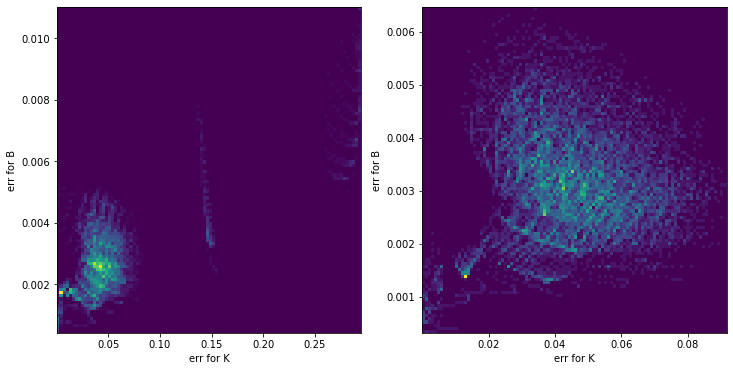

In [33]:
# check for errors
fig, ax =  plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].hist2d(ERR_K_2012.flatten()[(GR_2012.flatten()<=6)*(GR_2012.flatten()>=0)],ERR_B_2012.flatten()[(GR_2012.flatten()<=6)*(GR_2012.flatten()>=0)], bins=100)
ax[0].set_xlabel('err for K'); ax[0].set_ylabel('err for B'); 

ax[1].hist2d(ERR_K_2014.flatten()[(GR_2014.flatten()<=6)*(GR_2014.flatten()>=0)],ERR_B_2014.flatten()[(GR_2014.flatten()<=6)*(GR_2014.flatten()>=0)], bins=100)
ax[1].set_xlabel('err for K'); ax[1].set_ylabel('err for B'); 


In [34]:
# fig, ax =  plt.subplots(nrows=1, ncols=1, figsize=(2, 6))
# ax.plot(GM_towyo_2014['Vz'][:,0]**2,GM_towyo_2014['zw'])
# ax.plot(GM_towyo_2014['N2'][:,0]*4,GM_towyo_2014['zw'])

Text(0.5, 1.0, 'P5 2012')

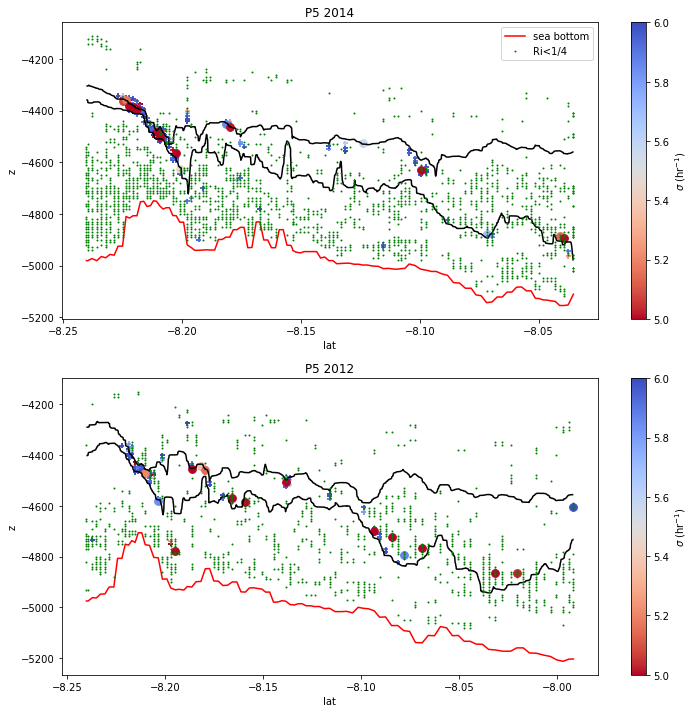

In [35]:
# critical level, GR along path
fig, ax =  plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
# ax[0].scatter(data_2014['lat'],data_2014['z'],c=data_2014['eps']) #c=np.log10(data_ex2['eps']))
ax[0].plot(FGM_towyo_2014.LAT, FGM_towyo_2014.bdepth, 'r-', label='sea bottom')
# ax[0].plot(FGM_towyo_2014.LAT, FGM_towyo_2014.zo, 'r--', label='interface')
ax[0].contour(data_2014['lat'],data_2014['z'],data_2014['sig4_sorted'],[1045.93, 1045.96],colors='k')
for i in range(len(GM_towyo_2014['LAT'])):  
    mask = GM_towyo_2014['Ri'][:,i]<1/4
    ax[0].plot(np.ones((len(GM_towyo_2014['zw'][mask])))*GM_towyo_2014['LAT'][i], GM_towyo_2014['zw'][mask], 'g.', ms=2)
ax[0].plot(np.ones((len(GM_towyo_2014['zw'][mask])))*GM_towyo_2014['LAT'][i], GM_towyo_2014['zw'][mask], 'g.', ms=2, label='Ri<1/4')
for i in range(len(GM_towyo_2014['LAT'])):  
    sc = ax[0].scatter(np.ones(len(CL_2014[i,:,:].flatten()[(GR_2014[i,:,:].flatten()<=6)*(GR_2014[i,:,:].flatten()>=0)]))*GM_towyo_2014['LAT'][i], CL_2014[i,:,:].flatten()[(GR_2014[i,:,:].flatten()<=6)*(GR_2014[i,:,:].flatten()>=0)],  c=GR_2014[i,:,:].flatten()[(GR_2014[i,:,:].flatten()<=6)*(GR_2014[i,:,:].flatten()>=0)], vmax=6, vmin=5, marker='+', s=25, cmap=cm.coolwarm_r)
for i in range(len(GM_towyo_2014['LAT'])):  
    if (np.min(GR_2014[i,:,:].flatten())<=6)*(np.min(GR_2014[i,:,:].flatten())>=0):
        ax[0].scatter(GM_towyo_2014['LAT'][i], CL_2014[i,:,:].flatten()[np.argmin(GR_2014[i,:,:].flatten())],  c=np.min(GR_2014[i,:,:].flatten()), vmax=6, vmin=5, marker='o', s=60, cmap=cm.coolwarm_r)
fig.colorbar(sc,label="$\sigma$ (hr$^{-1}$)",ax=ax[0])
ax[0].legend()
ax[0].set_xlabel('lat'); ax[0].set_ylabel('z'); ax[0].set_title('P5 2014')

# ax[1].scatter(data_2012['lat'],data_2012['z'],c=data_2012['eps']) #c=np.log10(data_ex2['eps']))
ax[1].plot(FGM_towyo_2012.LAT, FGM_towyo_2012.bdepth, 'r-', label='sea bottom')
# ax[1].plot(FGM_towyo_2012.LAT, FGM_towyo_2012.zo, 'r--', label='interface')
ax[1].contour(data_2012['lat'],data_2012['z'],data_2012['sig4_sorted'],[1045.93, 1045.96],colors='k')
for i in range(len(GM_towyo_2012['LAT'])):  
    mask = GM_towyo_2012['Ri'][:,i]<1/4
    ax[1].plot(np.ones((len(GM_towyo_2012['zw'][mask])))*GM_towyo_2012['LAT'][i], GM_towyo_2012['zw'][mask], 'g.', ms=2)
for i in range(len(GM_towyo_2012['LAT'])):  
    sc = ax[1].scatter(np.ones(len(CL_2012[i,:,:].flatten()[(GR_2012[i,:,:].flatten()<=6)*(GR_2012[i,:,:].flatten()>=0)]))*FGM_towyo_2012.LAT[i].data, CL_2012[i,:,:].flatten()[(GR_2012[i,:,:].flatten()<=6)*(GR_2012[i,:,:].flatten()>=0)],  c=GR_2012[i,:,:].flatten()[(GR_2012[i,:,:].flatten()<=6)*(GR_2012[i,:,:].flatten()>=0)], vmax=6, vmin=5, marker='+', s=25, cmap=cm.coolwarm_r)
for i in range(len(GM_towyo_2012['LAT'])):  
    if (np.min(GR_2012[i,:,:].flatten())<=6)*(np.min(GR_2012[i,:,:].flatten())>=0):
        ax[1].scatter(GM_towyo_2012['LAT'][i], CL_2012[i,:,:].flatten()[np.argmin(GR_2012[i,:,:].flatten())],  c=np.min(GR_2012[i,:,:].flatten()), vmax=6, vmin=5, marker='o', s=60, cmap=cm.coolwarm_r)
fig.colorbar(sc,label="$\sigma$ (hr$^{-1}$)",ax=ax[1])
ax[1].set_xlabel('lat'); ax[1].set_ylabel('z'); ax[1].set_title('P5 2012')

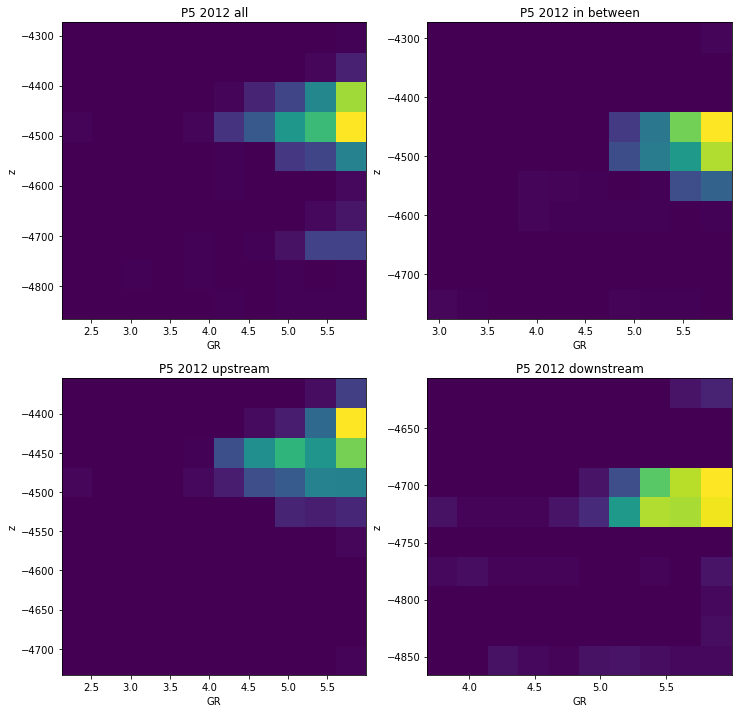

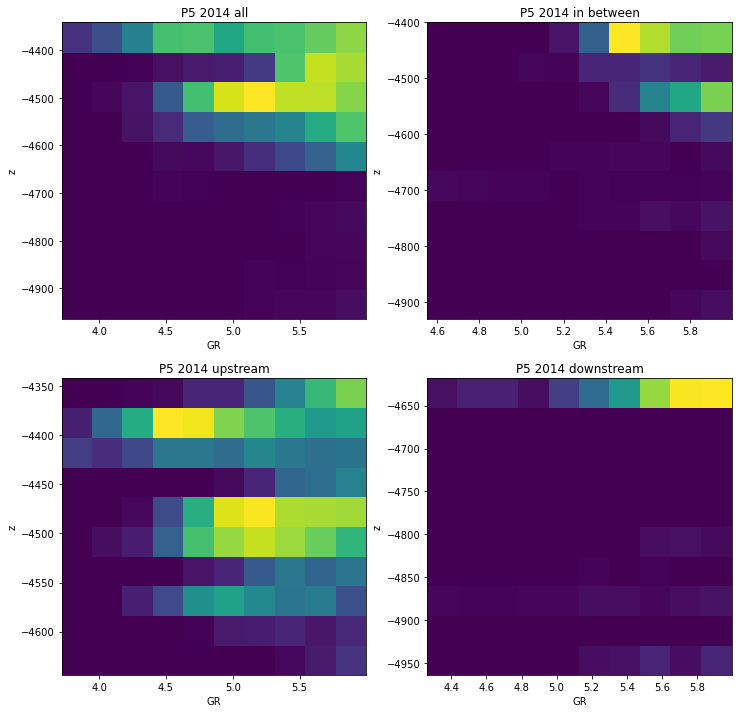

In [36]:
# 2012
fig, ax =  plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

nans = (GR_2012.flatten()<=6)*(GR_2012.flatten()>=0)
ax[0,0].hist2d(GR_2012.flatten()[nans],CL_2012.flatten()[nans])
ax[0,0].set_title('P5 2012 all'); ax[0,0].set_xlabel('GR'); ax[0,0].set_ylabel('z'); 

nans = (GR_2012[(GM_towyo_2012['LAT']<-8.1)*(GM_towyo_2012['LAT']>-8.2),:,:].flatten()<=6)*(GR_2012[(GM_towyo_2012['LAT']<-8.1)*(GM_towyo_2012['LAT']>-8.2),:,:].flatten()>=0)
ax[0,1].hist2d(GR_2012[(GM_towyo_2012['LAT']<-8.1)*(GM_towyo_2012['LAT']>-8.2),:,:].flatten()[nans],CL_2012[(GM_towyo_2012['LAT']<-8.1)*(GM_towyo_2012['LAT']>-8.2),:,:].flatten()[nans])
ax[0,1].set_title('P5 2012 in between'); ax[0,1].set_xlabel('GR'); ax[0,1].set_ylabel('z'); 

nans = (GR_2012[GM_towyo_2012['LAT']<=-8.2,:,:].flatten()<=6)*(GR_2012[GM_towyo_2012['LAT']<=-8.2,:,:].flatten()>=0)
ax[1,0].hist2d(GR_2012[GM_towyo_2012['LAT']<=-8.2,:,:].flatten()[nans],CL_2012[GM_towyo_2012['LAT']<=-8.2,:,:].flatten()[nans])
ax[1,0].set_title('P5 2012 upstream'); ax[1,0].set_xlabel('GR'); ax[1,0].set_ylabel('z'); 

nans = (GR_2012[GM_towyo_2012['LAT']>=-8.1,:,:].flatten()<=6)*(GR_2012[GM_towyo_2012['LAT']>=-8.1,:,:].flatten()>=0)
ax[1,1].hist2d(GR_2012[GM_towyo_2012['LAT']>=-8.1,:,:].flatten()[nans],CL_2012[GM_towyo_2012['LAT']>=-8.1,:,:].flatten()[nans])
ax[1,1].set_title('P5 2012 downstream'); ax[1,1].set_xlabel('GR'); ax[1,1].set_ylabel('z'); 


# 2014
fig, ax =  plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

nans = (GR_2014.flatten()<=6)*(GR_2014.flatten()>=0)
ax[0,0].hist2d(GR_2014.flatten()[nans],CL_2014.flatten()[nans])
ax[0,0].set_title('P5 2014 all'); ax[0,0].set_xlabel('GR'); ax[0,0].set_ylabel('z'); 

nans = (GR_2014[(GM_towyo_2014['LAT']<-8.1)*(GM_towyo_2014['LAT']>-8.2),:,:].flatten()<=6)*(GR_2014[(GM_towyo_2014['LAT']<-8.1)*(GM_towyo_2014['LAT']>-8.2),:,:].flatten()>=0)
ax[0,1].hist2d(GR_2014[(GM_towyo_2014['LAT']<-8.1)*(GM_towyo_2014['LAT']>-8.2),:,:].flatten()[nans],CL_2014[(GM_towyo_2014['LAT']<-8.1)*(GM_towyo_2014['LAT']>-8.2),:,:].flatten()[nans])
ax[0,1].set_title('P5 2014 in between'); ax[0,1].set_xlabel('GR'); ax[0,1].set_ylabel('z'); 

nans = (GR_2014[GM_towyo_2014['LAT']<=-8.2,:,:].flatten()<=6)*(GR_2014[GM_towyo_2014['LAT']<=-8.2,:,:].flatten()>=0)
ax[1,0].hist2d(GR_2014[GM_towyo_2014['LAT']<=-8.2,:,:].flatten()[nans],CL_2014[GM_towyo_2014['LAT']<=-8.2,:,:].flatten()[nans])
ax[1,0].set_title('P5 2014 upstream'); ax[1,0].set_xlabel('GR'); ax[1,0].set_ylabel('z'); 

nans = (GR_2014[GM_towyo_2014['LAT']>=-8.1,:,:].flatten()<=6)*(GR_2014[GM_towyo_2014['LAT']>=-8.1,:,:].flatten()>=0)
ax[1,1].hist2d(GR_2014[GM_towyo_2014['LAT']>=-8.1,:,:].flatten()[nans],CL_2014[GM_towyo_2014['LAT']>=-8.1,:,:].flatten()[nans])
ax[1,1].set_title('P5 2014 downstream'); ax[1,1].set_xlabel('GR'); ax[1,1].set_ylabel('z'); 



In [37]:
# GR vs sig4_sorted
CL_2012_sig4 = np.zeros(CL_2012.shape) + np.nan
for i in range(len(GM_towyo_2012['LAT'])):  
    f=interp1d(data_2012['z'][:,i],data_2012['sig4_sorted'][:,i])
    CL_2012_sig4[i,:,:] = f(CL_2012[i,:,:])

CL_2014_sig4 = np.zeros(CL_2014.shape) + np.nan
for i in range(len(GM_towyo_2014['LAT'])):  
    f=interp1d(data_2014['z'][:,i],data_2014['sig4_sorted'][:,i])
    CL_2014_sig4[i,:,:] = f(CL_2014[i,:,:])


(45.99, 45.9)

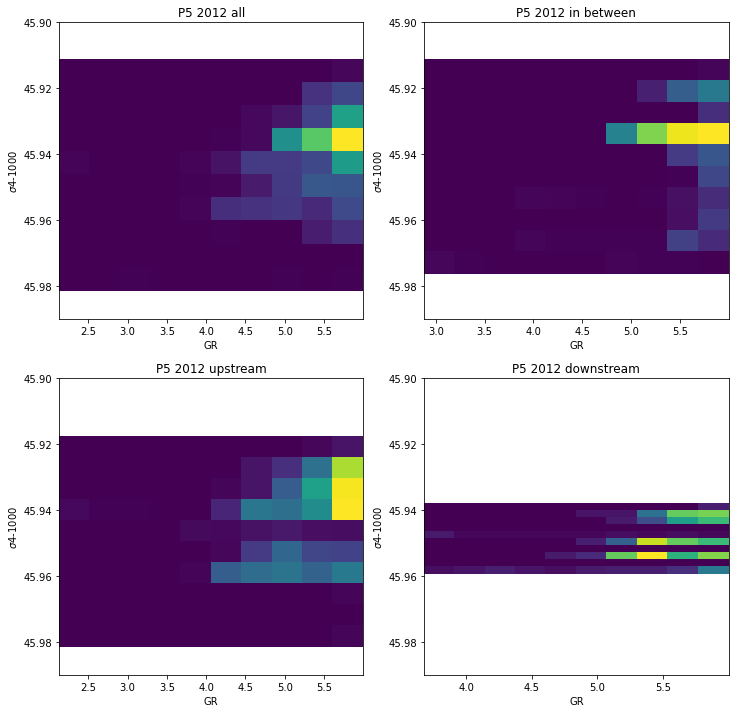

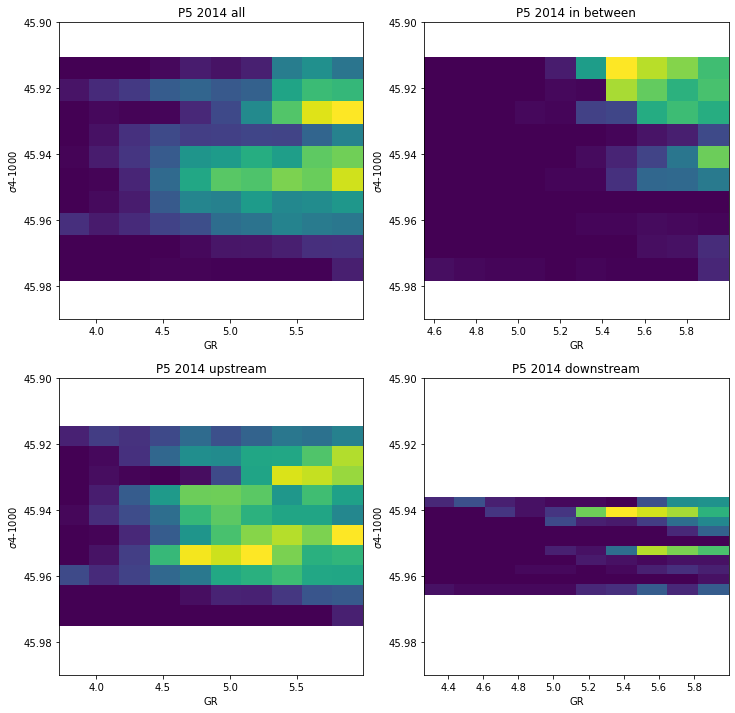

In [38]:
# 2012
fig, ax =  plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

nans = (~np.isnan(CL_2012_sig4.flatten()))*(GR_2012.flatten()<=6)*(GR_2012.flatten()>=0)
ax[0,0].hist2d(GR_2012.flatten()[nans],CL_2012_sig4.flatten()[nans]-1000)
ax[0,0].set_title('P5 2012 all'); ax[0,0].set_xlabel('GR'); ax[0,0].set_ylabel('$\sigma$4-1000'); ax[0,0].set_ylim(45.99,45.9) 

nans = (~np.isnan(CL_2012_sig4[(GM_towyo_2012['LAT']<-8.1)*(GM_towyo_2012['LAT']>-8.2),:,:].flatten()))*(GR_2012[(GM_towyo_2012['LAT']<-8.1)*(GM_towyo_2012['LAT']>-8.2),:,:].flatten()<=6)*(GR_2012[(GM_towyo_2012['LAT']<-8.1)*(GM_towyo_2012['LAT']>-8.2),:,:].flatten()>=0)
ax[0,1].hist2d(GR_2012[(GM_towyo_2012['LAT']<-8.1)*(GM_towyo_2012['LAT']>-8.2),:,:].flatten()[nans],CL_2012_sig4[(GM_towyo_2012['LAT']<-8.1)*(GM_towyo_2012['LAT']>-8.2),:,:].flatten()[nans]-1000)
ax[0,1].set_title('P5 2012 in between'); ax[0,1].set_xlabel('GR'); ax[0,1].set_ylabel('$\sigma$4-1000'); ax[0,1].set_ylim(45.99,45.9) 

nans = (~np.isnan(CL_2012_sig4[GM_towyo_2012['LAT']<=-8.2,:,:].flatten()))*(GR_2012[GM_towyo_2012['LAT']<=-8.2,:,:].flatten()<=6)*(GR_2012[GM_towyo_2012['LAT']<=-8.2,:,:].flatten()>=0)
ax[1,0].hist2d(GR_2012[GM_towyo_2012['LAT']<=-8.2,:,:].flatten()[nans],CL_2012_sig4[GM_towyo_2012['LAT']<=-8.2,:,:].flatten()[nans]-1000)
ax[1,0].set_title('P5 2012 upstream'); ax[1,0].set_xlabel('GR'); ax[1,0].set_ylabel('$\sigma$4-1000'); ax[1,0].set_ylim(45.99,45.9) 

nans = (~np.isnan(CL_2012_sig4[GM_towyo_2012['LAT']>=-8.1,:,:].flatten()))*(GR_2012[GM_towyo_2012['LAT']>=-8.1,:,:].flatten()<=6)*(GR_2012[GM_towyo_2012['LAT']>=-8.1,:,:].flatten()>=0)
ax[1,1].hist2d(GR_2012[GM_towyo_2012['LAT']>=-8.1,:,:].flatten()[nans],CL_2012_sig4[GM_towyo_2012['LAT']>=-8.1,:,:].flatten()[nans]-1000)
ax[1,1].set_title('P5 2012 downstream'); ax[1,1].set_xlabel('GR'); ax[1,1].set_ylabel('$\sigma$4-1000'); ax[1,1].set_ylim(45.99,45.9) 

# 2014
fig, ax =  plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

nans = (~np.isnan(CL_2014_sig4.flatten()))*(GR_2014.flatten()<=6)*(GR_2014.flatten()>=0)
ax[0,0].hist2d(GR_2014.flatten()[nans],CL_2014_sig4.flatten()[nans]-1000)
ax[0,0].set_title('P5 2014 all'); ax[0,0].set_xlabel('GR'); ax[0,0].set_ylabel('$\sigma$4-1000'); ax[0,0].set_ylim(45.99,45.9) 

nans = (~np.isnan(CL_2014_sig4[(GM_towyo_2014['LAT']<-8.1)*(GM_towyo_2014['LAT']>-8.2),:,:].flatten()))*(GR_2014[(GM_towyo_2014['LAT']<-8.1)*(GM_towyo_2014['LAT']>-8.2),:,:].flatten()<=6)*(GR_2014[(GM_towyo_2014['LAT']<-8.1)*(GM_towyo_2014['LAT']>-8.2),:,:].flatten()>=0)
ax[0,1].hist2d(GR_2014[(GM_towyo_2014['LAT']<-8.1)*(GM_towyo_2014['LAT']>-8.2),:,:].flatten()[nans],CL_2014_sig4[(GM_towyo_2014['LAT']<-8.1)*(GM_towyo_2014['LAT']>-8.2),:,:].flatten()[nans]-1000)
ax[0,1].set_title('P5 2014 in between'); ax[0,1].set_xlabel('GR'); ax[0,1].set_ylabel('$\sigma$4-1000'); ax[0,1].set_ylim(45.99,45.9) 

nans = (~np.isnan(CL_2014_sig4[GM_towyo_2014['LAT']<=-8.2,:,:].flatten()))*(GR_2014[GM_towyo_2014['LAT']<=-8.2,:,:].flatten()<=6)*(GR_2014[GM_towyo_2014['LAT']<=-8.2,:,:].flatten()>=0)
ax[1,0].hist2d(GR_2014[GM_towyo_2014['LAT']<=-8.2,:,:].flatten()[nans],CL_2014_sig4[GM_towyo_2014['LAT']<=-8.2,:,:].flatten()[nans]-1000)
ax[1,0].set_title('P5 2014 upstream'); ax[1,0].set_xlabel('GR'); ax[1,0].set_ylabel('$\sigma$4-1000'); ax[1,0].set_ylim(45.99,45.9) 

nans = (~np.isnan(CL_2014_sig4[GM_towyo_2014['LAT']>=-8.1,:,:].flatten()))*(GR_2014[GM_towyo_2014['LAT']>=-8.1,:,:].flatten()<=6)*(GR_2014[GM_towyo_2014['LAT']>=-8.1,:,:].flatten()>=0)
ax[1,1].hist2d(GR_2014[GM_towyo_2014['LAT']>=-8.1,:,:].flatten()[nans],CL_2014_sig4[GM_towyo_2014['LAT']>=-8.1,:,:].flatten()[nans]-1000)
ax[1,1].set_title('P5 2014 downstream'); ax[1,1].set_xlabel('GR'); ax[1,1].set_ylabel('$\sigma$4-1000'); ax[1,1].set_ylim(45.99,45.9) 
